# Import Library

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Bidirectional, Dense, Dropout
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import os
import json
import time
import seaborn as sns

# Load Data

In [172]:
train_url = 'https://drive.google.com/uc?id=1EjwYiF0n6SB9b4pjOC9OgERiW-qFs1Xv'
valid_url = 'https://drive.google.com/uc?id=10nEhcFT5WYRQL462zAsYGrKH9h09Ll9X'
test_url = 'https://drive.google.com/uc?id=1mvbRKOWCx3CFh57NLr-_uV77Zr-uC7Bw'

train_df = pd.read_csv(train_url)
valid_df = pd.read_csv(valid_url)
test_df = pd.read_csv(test_url)

print(f"Jumlah data train: {len(train_df)}")
print(f"Jumlah data validation: {len(valid_df)}")
print(f"Jumlah data test: {len(test_df)}")

print("\nDistribusi label data train:")
print(train_df['label'].value_counts())
print("\nDistribusi label data validation:")
print(valid_df['label'].value_counts())
print("\nDistribusi label data test:")
print(test_df['label'].value_counts())

print("\nContoh data:")
print(train_df.head())

Jumlah data train: 500
Jumlah data validation: 100
Jumlah data test: 400

Distribusi label data train:
negative    192
positive    189
neutral     119
Name: label, dtype: int64

Distribusi label data validation:
negative    38
positive    38
neutral     24
Name: label, dtype: int64

Distribusi label data test:
negative    153
positive    151
neutral      96
Name: label, dtype: int64

Contoh data:
    id                                               text     label
0  219  Nikmati cicilan 0% hingga 12 bulan untuk pemes...   neutral
1  209  Kue-kue yang disajikan bikin saya bernostalgia...  positive
2  436               Ibu pernah bekerja di grab indonesia   neutral
3  394  Paling suka banget makan siang di sini ayam sa...  positive
4  592                    Pelayanan bus DAMRI sangat baik  positive


# Tokenisasi dan Embedding

In [173]:
# Label jadiin indeks numerik
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

# Extract data teks dan label
X_train = train_df['text'].values
y_train = np.array([label_mapping[label] for label in train_df['label']])
X_valid = valid_df['text'].values
y_valid = np.array([label_mapping[label] for label in valid_df['label']])
X_test = test_df['text'].values
y_test = np.array([label_mapping[label] for label in test_df['label']])

max_features = 10000  # Jumlah max token
sequence_length = 100  # Panjang max sequence

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

# Train text vectorizer
vectorize_layer.adapt(X_train)

# Vocabulary yang dihasilkan
vocab = vectorize_layer.get_vocabulary()
print(f"Jumlah vocabulary: {len(vocab)}")
# print(f"Vocab examples: {vocab[:10]}")

train_vectors = vectorize_layer(X_train).numpy()
valid_vectors = vectorize_layer(X_valid).numpy()
test_vectors = vectorize_layer(X_test).numpy()

# Dataset TF
batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((train_vectors, y_train)).batch(batch_size)
valid_ds = tf.data.Dataset.from_tensor_slices((valid_vectors, y_valid)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((test_vectors, y_test)).batch(batch_size)

Jumlah vocabulary: 2836


# Train n Evaluate Model

In [174]:
def train_and_evaluate_model(model, epochs=10, save_path=None):
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    if save_path:
        callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath=save_path,
                save_best_only=True,
                monitor='val_loss',
                mode='min'
            )
        ]
    else:
        callbacks = []
    
    # Train model
    history = model.fit(
        train_ds,
        validation_data=valid_ds,
        epochs=epochs,
        callbacks=callbacks
    )
    
    # Evaluasi model pada data test
    y_pred_probs = model.predict(test_vectors)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Hitung f1-score
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    print(f"Macro F1-Score: {macro_f1:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=list(label_mapping.keys())))
    
    return history, macro_f1, y_pred

def plot_history(history, title):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"result_lstm/{title.replace(' ', '_')}.png")
    plt.show()

# Variasi Jumlah Layer LSTM


Training LSTM model with 1 layer(s)
Epoch 1/10
14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3390 - loss: 1.0986

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3411 - loss: 1.0972 - val_accuracy: 0.3800 - val_loss: 1.0789
Epoch 2/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3873 - loss: 1.0808

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3862 - loss: 1.0809 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3546 - loss: 1.0814 - val_accuracy: 0.3800 - val_loss: 1.0800
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3764 - loss: 1.0851 - val_accuracy: 0.3800 - val_loss: 1.0790
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3992 - loss: 1.0862 - val_accuracy: 0.3800 - val_loss: 1.0792
Epoch 6/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3883 - loss: 1.0836

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3890 - loss: 1.0835 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3917 - loss: 1.0842 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3623 - loss: 1.0826 - val_accuracy: 0.3800 - val_loss: 1.0789
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3721 - loss: 1.0875 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3973 - loss: 1.0790 - val_accuracy: 0.3800 - val_loss: 1.0781
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Macro F1-Score: 0.1844

Classification Report:
              precision    recall  f1-score   support

    negative       0.38      1.00      0.55       153
     neutral       0.00      0.00      0.00        96
    positive       0.00      0.00      0.00       151

    accuracy                           0.38       400
   macro avg    

c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

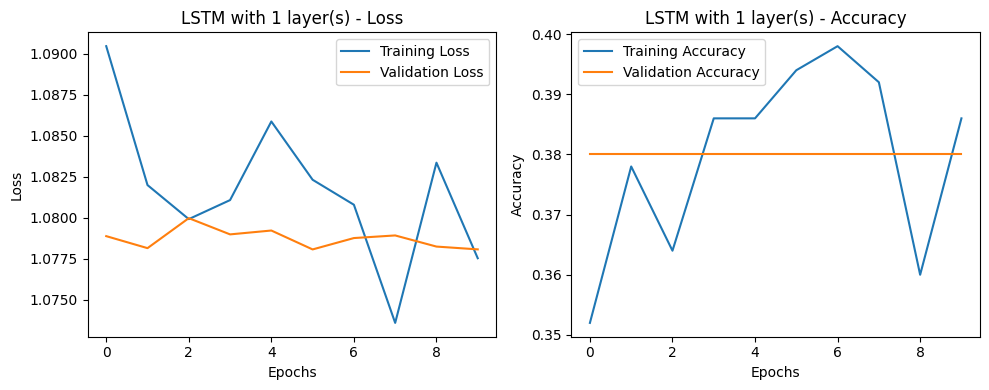


Training LSTM model with 2 layer(s)
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3316 - loss: 1.1001

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.3327 - loss: 1.1000 - val_accuracy: 0.3800 - val_loss: 1.0832
Epoch 2/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4208 - loss: 1.0730

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4188 - loss: 1.0736 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3741 - loss: 1.0893 - val_accuracy: 0.3800 - val_loss: 1.0819
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3756 - loss: 1.1006 - val_accuracy: 0.3800 - val_loss: 1.0791
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3707 - loss: 1.0891 - val_accuracy: 0.3800 - val_loss: 1.0786
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3670 - loss: 1.0907 - val_accuracy: 0.3800 - val_loss: 1.0812
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3813 - loss: 1.0838 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4228 - loss: 1.0829 - val_accuracy: 0.3800 - val_loss: 1.0803
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3458 - loss: 1.0882 - val_accuracy: 0.3800 - val_loss: 1.

c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

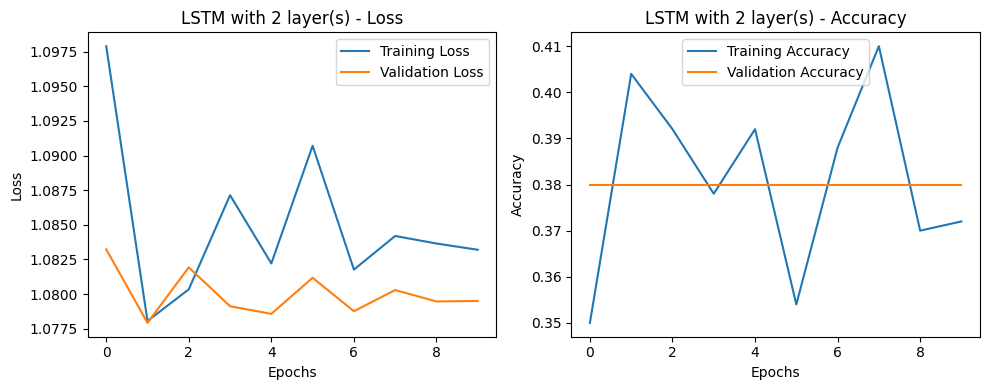


Training LSTM model with 3 layer(s)
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4079 - loss: 1.0917

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.4073 - loss: 1.0917 - val_accuracy: 0.3800 - val_loss: 1.0826
Epoch 2/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3623 - loss: 1.0882

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.3644 - loss: 1.0876 - val_accuracy: 0.3800 - val_loss: 1.0796
Epoch 3/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3195 - loss: 1.0880

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.3240 - loss: 1.0873 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.3608 - loss: 1.0891 - val_accuracy: 0.3800 - val_loss: 1.0793
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.3620 - loss: 1.0867 - val_accuracy: 0.3800 - val_loss: 1.0795
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.3929 - loss: 1.0788 - val_accuracy: 0.3800 - val_loss: 1.0824
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.3576 - loss: 1.0923 - val_accuracy: 0.3800 - val_loss: 1.0813
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.3744 - loss: 1.0859 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.3297 - loss: 1.0841 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.3950 - loss: 1.0820 - val_accuracy: 0.3800 - val_loss: 1

c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

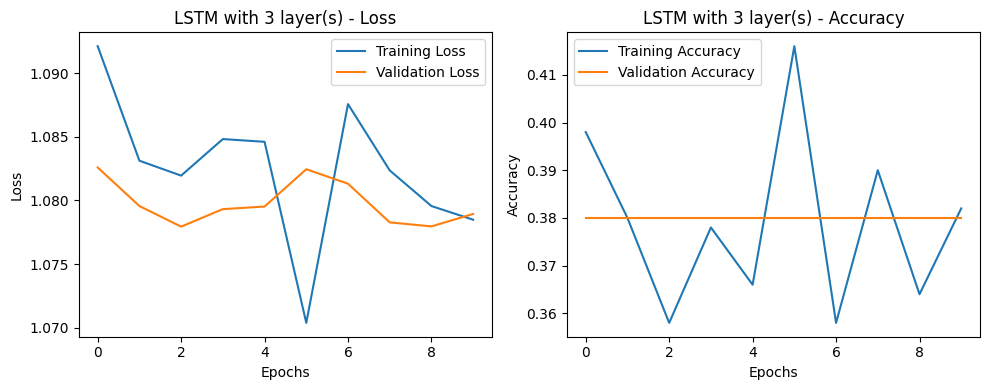


Perbandingan Hasil Berdasarkan Jumlah Layer LSTM:
Jumlah Layer: 1, Macro F1-Score: 0.1844
Jumlah Layer: 2, Macro F1-Score: 0.1844
Jumlah Layer: 3, Macro F1-Score: 0.1827


In [175]:
# Variasi jumlah layer LSTM
embedding_dim = 128
lstm_units = 64
dropout_rate = 0.5
num_classes = len(label_mapping)  # 3 kelas: negative, neutral, positive

def create_lstm_model(num_layers, lstm_units=64, bidirectional=False):
    inputs = keras.Input(shape=(sequence_length,))
    x = Embedding(max_features + 1, embedding_dim)(inputs)
    
    for i in range(num_layers):
        if bidirectional:
            x = Bidirectional(LSTM(lstm_units, return_sequences=(i < num_layers-1)))(x)
        else:
            x = LSTM(lstm_units, return_sequences=(i < num_layers-1))(x)
        
        x = Dropout(dropout_rate)(x)
    
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    return model

# Buat dan train model dengan variasi jumlah layer
num_layers_variations = [1, 2, 3]
layer_results = []

for num_layers in num_layers_variations:
    print(f"\n{'='*50}")
    print(f"Training LSTM model with {num_layers} layer(s)")
    print(f"{'='*50}")
    
    model = create_lstm_model(num_layers=num_layers)
    save_path = f'result_lstm/lstm_num_layers_{num_layers}.h5'
    
    history, f1, _ = train_and_evaluate_model(model, epochs=10, save_path=save_path)
    plot_history(history, f"LSTM with {num_layers} layer(s)")
    
    layer_results.append({
        'num_layers': num_layers,
        'macro_f1': f1,
        'model_path': save_path
    })

print("\nPerbandingan Hasil Berdasarkan Jumlah Layer LSTM:")
for result in layer_results:
    print(f"Jumlah Layer: {result['num_layers']}, Macro F1-Score: {result['macro_f1']:.4f}")

# Variasi Jumlah Cell LSTM Per Layer


Training LSTM model with 32 units per layer
Epoch 1/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3973 - loss: 1.0938

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.3945 - loss: 1.0940 - val_accuracy: 0.3800 - val_loss: 1.0838
Epoch 2/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4285 - loss: 1.0861

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4263 - loss: 1.0857 - val_accuracy: 0.3800 - val_loss: 1.0798
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3736 - loss: 1.0953 - val_accuracy: 0.3800 - val_loss: 1.0800
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3980 - loss: 1.0841 - val_accuracy: 0.3800 - val_loss: 1.0808
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3249 - loss: 1.0917 - val_accuracy: 0.3800 - val_loss: 1.0824
Epoch 6/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3989 - loss: 1.0839

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3969 - loss: 1.0839 - val_accuracy: 0.3800 - val_loss: 1.0789
Epoch 7/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3888 - loss: 1.0855

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3891 - loss: 1.0850 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 8/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3826 - loss: 1.0797

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3839 - loss: 1.0795 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4352 - loss: 1.0819 - val_accuracy: 0.3800 - val_loss: 1.0795
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3830 - loss: 1.0790 - val_accuracy: 0.3800 - val_loss: 1.0798
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Macro F1-Score: 0.1844

Classification Report:
              precision    recall  f1-score   support

    negative       0.38      1.00      0.55       153
     neutral       0.00      0.00      0.00        96
    positive       0.00      0.00      0.00       151

    accuracy                           0.38       400
   macro avg       0.13      0.33      0.18       400
weighted avg       0.15      0.38      0.21       400



c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

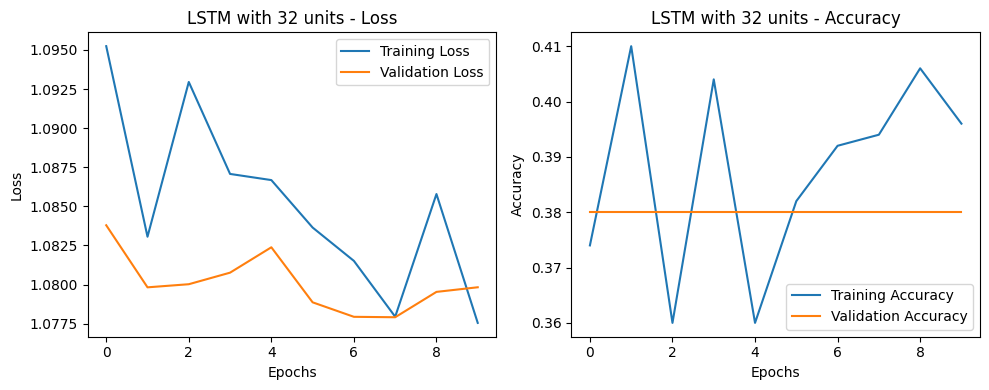


Training LSTM model with 64 units per layer
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3737 - loss: 1.0952

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.3734 - loss: 1.0950 - val_accuracy: 0.3800 - val_loss: 1.0796
Epoch 2/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3260 - loss: 1.0910

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3284 - loss: 1.0905 - val_accuracy: 0.3800 - val_loss: 1.0796
Epoch 3/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3776 - loss: 1.0837

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3779 - loss: 1.0836 - val_accuracy: 0.3800 - val_loss: 1.0790
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3429 - loss: 1.0846 - val_accuracy: 0.3800 - val_loss: 1.0807
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3602 - loss: 1.0891 - val_accuracy: 0.3800 - val_loss: 1.0793
Epoch 6/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4000 - loss: 1.0806

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3983 - loss: 1.0800 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 7/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3917 - loss: 1.0860

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3901 - loss: 1.0855 - val_accuracy: 0.3800 - val_loss: 1.0787
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4021 - loss: 1.0905 - val_accuracy: 0.3800 - val_loss: 1.0793
Epoch 9/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3827 - loss: 1.0877

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.3808 - loss: 1.0875 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 10/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3576 - loss: 1.0866

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3607 - loss: 1.0857 - val_accuracy: 0.3800 - val_loss: 1.0779
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Macro F1-Score: 0.1827

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       153
     neutral       0.00      0.00      0.00        96
    positive       0.38      1.00      0.55       151

    accuracy                           0.38       400
   macro avg       0.13      0.33      0.18       400
weighted avg       0.14      0.38      0.21       400



c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

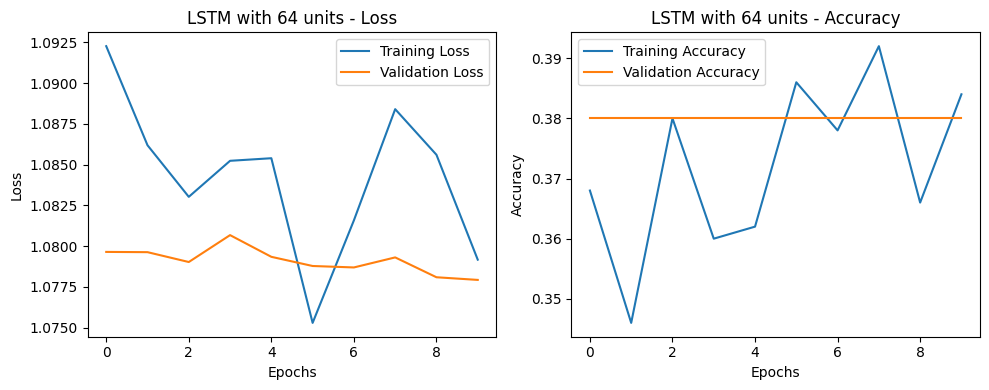


Training LSTM model with 128 units per layer
Epoch 1/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3668 - loss: 1.0979

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.3664 - loss: 1.0977 - val_accuracy: 0.3800 - val_loss: 1.0846
Epoch 2/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3507 - loss: 1.0967

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.3523 - loss: 1.0962 - val_accuracy: 0.3800 - val_loss: 1.0810
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3812 - loss: 1.0845

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.3820 - loss: 1.0843 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.3777 - loss: 1.0905 - val_accuracy: 0.3800 - val_loss: 1.0806
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.3200 - loss: 1.0855 - val_accuracy: 0.3800 - val_loss: 1.0809
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.3564 - loss: 1.0892 - val_accuracy: 0.3800 - val_loss: 1.0803
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.3365 - loss: 1.0916 - val_accuracy: 0.3800 - val_loss: 1.0785
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.3927 - loss: 1.0819 - val_accuracy: 0.3800 - val_loss: 1.0800
Epoch 9/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3434 - loss: 1.0925

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.3470 - loss: 1.0910 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.3938 - loss: 1.0840 - val_accuracy: 0.3800 - val_loss: 1.0804
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Macro F1-Score: 0.1844

Classification Report:
              precision    recall  f1-score   support

    negative       0.38      1.00      0.55       153
     neutral       0.00      0.00      0.00        96
    positive       0.00      0.00      0.00       151

    accuracy                           0.38       400
   macro avg       0.13      0.33      0.18       400
weighted avg       0.15      0.38      0.21       400



c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

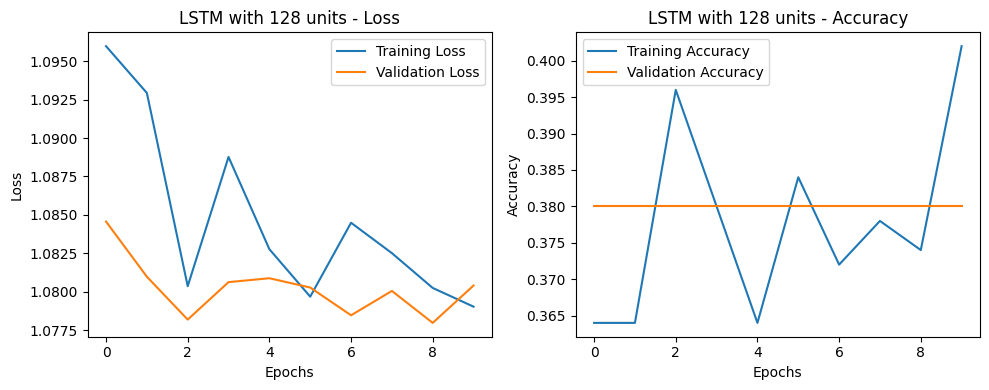


Perbandingan Hasil Berdasarkan Jumlah Cell LSTM Per Layer:
Jumlah Cell: 32, Macro F1-Score: 0.1844
Jumlah Cell: 64, Macro F1-Score: 0.1827
Jumlah Cell: 128, Macro F1-Score: 0.1844


In [176]:
# Variasi jumlah cell LSTM per layer
lstm_units_variations = [32, 64, 128]
cell_results = []

for units in lstm_units_variations:
    print(f"\n{'='*50}")
    print(f"Training LSTM model with {units} units per layer")
    print(f"{'='*50}")
    
    model = create_lstm_model(num_layers=2, lstm_units=units)
    save_path = f'result_lstm/lstm_units_{units}.h5'
    
    history, f1, _ = train_and_evaluate_model(model, epochs=10, save_path=save_path)
    plot_history(history, f"LSTM with {units} units")
    
    cell_results.append({
        'units': units,
        'macro_f1': f1,
        'model_path': save_path
    })

print("\nPerbandingan Hasil Berdasarkan Jumlah Cell LSTM Per Layer:")
for result in cell_results:
    print(f"Jumlah Cell: {result['units']}, Macro F1-Score: {result['macro_f1']:.4f}")

# Variasi Arah LSTM (Unidirectional vs Bidirectional)


Training Unidirectional LSTM model
Epoch 1/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3293 - loss: 1.0993

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.3296 - loss: 1.0990 - val_accuracy: 0.3800 - val_loss: 1.0794
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3790 - loss: 1.0934 - val_accuracy: 0.3800 - val_loss: 1.0797
Epoch 3/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3964 - loss: 1.0880

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3940 - loss: 1.0873 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3564 - loss: 1.0861 - val_accuracy: 0.3800 - val_loss: 1.0805
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3728 - loss: 1.0924 - val_accuracy: 0.3800 - val_loss: 1.0821
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.3753 - loss: 1.0819 - val_accuracy: 0.3800 - val_loss: 1.0790
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.3931 - loss: 1.0709 - val_accuracy: 0.3800 - val_loss: 1.0803
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.3363 - loss: 1.0977 - val_accuracy: 0.3800 - val_loss: 1.0801
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.3732 - loss: 1.0805 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3379 - loss: 1.0797 - val_accuracy: 0.3800 - val_loss: 1

c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

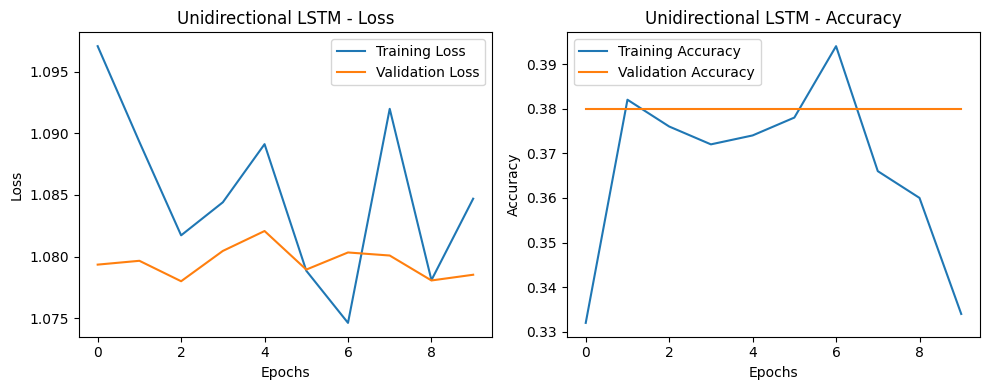


Training Bidirectional LSTM model
Epoch 1/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3283 - loss: 1.0937

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.3306 - loss: 1.0927 - val_accuracy: 0.3800 - val_loss: 1.0599
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3759 - loss: 1.0385

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.3806 - loss: 1.0359 - val_accuracy: 0.5200 - val_loss: 0.9496
Epoch 3/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5259 - loss: 0.9170

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5264 - loss: 0.9172 - val_accuracy: 0.5300 - val_loss: 0.9232
Epoch 4/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6580 - loss: 0.7261

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6615 - loss: 0.7253 - val_accuracy: 0.6100 - val_loss: 0.8410
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7653 - loss: 0.5760 - val_accuracy: 0.6000 - val_loss: 0.8696
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8320 - loss: 0.4293 - val_accuracy: 0.6100 - val_loss: 0.9789
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9528 - loss: 0.2017 - val_accuracy: 0.6600 - val_loss: 1.2961
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9791 - loss: 0.0996 - val_accuracy: 0.6700 - val_loss: 1.5802
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9831 - loss: 0.0896 - val_accuracy: 0.6500 - val_loss: 1.4419
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9849 - loss: 0.0490 - val_accuracy: 0.6800 - val_loss: 1.7119
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Macro F1-Score: 0.6662

Classification Report:
              precision    recall 

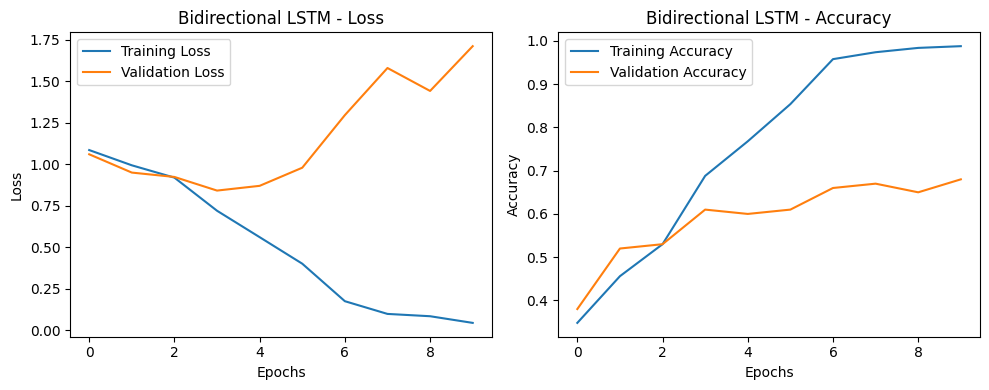


Perbandingan Hasil Berdasarkan Arah LSTM:
Arah: Unidirectional, Macro F1-Score: 0.1827
Arah: Bidirectional, Macro F1-Score: 0.6662


In [177]:
# Variasi arah LSTM (unidirectional vs bidirectional)
direction_variations = [False, True]  # False untuk unidirectional, True untuk bidirectional
direction_results = []

for bidirectional in direction_variations:
    direction_name = "Bidirectional" if bidirectional else "Unidirectional"
    print(f"\n{'='*50}")
    print(f"Training {direction_name} LSTM model")
    print(f"{'='*50}")
    
    model = create_lstm_model(num_layers=2, lstm_units=64, bidirectional=bidirectional)
    save_path = f'result_lstm/lstm_{direction_name.lower()}.h5'
    
    history, f1, _ = train_and_evaluate_model(model, epochs=10, save_path=save_path)
    plot_history(history, f"{direction_name} LSTM")
    
    direction_results.append({
        'direction': direction_name,
        'macro_f1': f1,
        'model_path': save_path
    })

print("\nPerbandingan Hasil Berdasarkan Arah LSTM:")
for result in direction_results:
    print(f"Arah: {result['direction']}, Macro F1-Score: {result['macro_f1']:.4f}")

# Forward Propagation (From Scratch)

In [178]:
class LSTMCell:
    def __init__(self, input_dim, hidden_dim):
        # Inisialisasi weights dan bias
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.Wi = None
        self.Ui = None
        self.bi = None
        self.cache = {}
        
    def load_weights(self, weights, bias):
        # Load weights dari LSTM cell Keras
        # - Wi: Input weights untuk gate input, forget, cell, output (format: [input_dim, 4*hidden_dim])
        # - Ui: Recurrent weights (format: [hidden_dim, 4*hidden_dim])
        # - bi: Biases (format: [4*hidden_dim])
        # Weights untuk gate input, forget, cell, dan output
        self.Wi = weights[0]  # Input weights
        self.Ui = weights[1]  # Recurrent weights
        self.bi = bias[0]   # Biases
    
    def forward(self, x, h_prev, c_prev): # Forward pass untuk satu time step
        # x: Input pada time step ini [batch_size, input_dim]
        # h_prev: Hidden state sebelumnya [batch_size, hidden_dim]
        # c_prev: Cell state sebelumnya [batch_size, hidden_dim]
        # h_next: Hidden state berikutnya
        # c_next: Cell state berikutnya
        # Gates: i (input), f (forget), c (cell), o (output)
        # Perhitungan: [batch_size, input_dim] @ [input_dim, 4*hidden_dim] + [batch_size, hidden_dim] @ [hidden_dim, 4*hidden_dim] + [4*hidden_dim]
        gates = np.dot(x, self.Wi) + np.dot(h_prev, self.Ui) + self.bi
        
        i, f, c, o = np.split(gates, 4, axis=1)
        
        i_gate = sigmoid(i)  # Input gate
        f_gate = sigmoid(f)  # Forget gate
        c_tilde = np.tanh(c)  # Cell input
        o_gate = sigmoid(o)  # Output gate
        
        c_next = f_gate * c_prev + i_gate * c_tilde
        h_next = o_gate * np.tanh(c_next)
        
        self.cache = {
            'x': x, 'h_prev': h_prev, 'c_prev': c_prev,
            'i_gate': i_gate, 'f_gate': f_gate, 'c_tilde': c_tilde, 'o_gate': o_gate,
            'c_next': c_next, 'h_next': h_next
        }
        
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        x = self.cache['x']
        h_prev = self.cache['h_prev']
        c_prev = self.cache['c_prev']
        i_gate = self.cache['i_gate']
        f_gate = self.cache['f_gate']
        c_tilde = self.cache['c_tilde']
        o_gate = self.cache['o_gate']
        c_next = self.cache['c_next']
        
        # Gradien untuk o_gate
        do_gate = dh_next * np.tanh(c_next)
        
        # Gradien untuk c_next
        dc_next = dc_next + dh_next * o_gate * (1 - np.tanh(c_next)**2)
        
        # Gradien untuk f_gate
        df_gate = dc_next * c_prev
        
        # Gradien untuk i_gate
        di_gate = dc_next * c_tilde
        
        # Gradien untuk c_tilde
        dc_tilde = dc_next * i_gate
        
        # Gradien untuk c_prev
        dc_prev = dc_next * f_gate
        
        # Gradien untuk gates sebelum aktivasi
        di = di_gate * i_gate * (1 - i_gate)  # Sigmoid derivative
        df = df_gate * f_gate * (1 - f_gate)  # Sigmoid derivative
        dc = dc_tilde * (1 - c_tilde**2)  # Tanh derivative
        do = do_gate * o_gate * (1 - o_gate)  # Sigmoid derivative
        
        # Gabungkan gradien untuk semua gates
        dgates = np.concatenate([di, df, dc, do], axis=1)
        
        # Gradien untuk x, h_prev, Wi, Ui, bi
        dx = np.dot(dgates, self.Wi.T)
        dh_prev = np.dot(dgates, self.Ui.T)
        dWi = np.dot(x.T, dgates)
        dUi = np.dot(h_prev.T, dgates)
        dbi = np.sum(dgates, axis=0)
        
        return dx, dh_prev, dc_prev, dWi, dUi, dbi
    
def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -30, 30)))  

def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True)) 
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [179]:
class UnidirectionalLSTMLayer:
    def __init__(self, input_dim, hidden_dim):
        self.lstm_cell = LSTMCell(input_dim, hidden_dim)
        self.hidden_dim = hidden_dim
        self.cache = {}
        
    def load_weights(self, keras_layer):
        weights = keras_layer.get_weights()
        self.lstm_cell.load_weights(weights[:2], [weights[2]])
    
    def forward(self, x, return_sequences=False):
        batch_size, time_steps, input_dim = x.shape
        
        h = np.zeros((batch_size, self.hidden_dim))
        c = np.zeros((batch_size, self.hidden_dim))
        
        outputs = np.zeros((batch_size, time_steps, self.hidden_dim)) if return_sequences else None
        
        h_states = []
        c_states = []
        
        for t in range(time_steps):
            h, c = self.lstm_cell.forward(x[:, t, :], h, c)
            h_states.append(h)
            c_states.append(c)
            if return_sequences:
                outputs[:, t, :] = h
        
        self.cache = {
            'x': x,
            'h_states': h_states,
            'c_states': c_states,
            'return_sequences': return_sequences,
            'time_steps': time_steps
        }
        
        if return_sequences:
            return outputs
        else:
            return h
    
    def backward(self, dout):
        x = self.cache['x']
        h_states = self.cache['h_states']
        c_states = self.cache['c_states']
        return_sequences = self.cache['return_sequences']
        time_steps = self.cache['time_steps']
        batch_size, _, input_dim = x.shape
        
        dx = np.zeros_like(x)
        dWi = np.zeros_like(self.lstm_cell.Wi)
        dUi = np.zeros_like(self.lstm_cell.Ui)
        dbi = np.zeros_like(self.lstm_cell.bi)
        
        dh_next = np.zeros((batch_size, self.hidden_dim))
        dc_next = np.zeros((batch_size, self.hidden_dim))
        
        for t in reversed(range(time_steps)):
            if return_sequences:
                dh_next += dout[:, t, :]
            elif t == time_steps - 1:
                dh_next += dout
            
            dx_t, dh_next, dc_next, dWi_t, dUi_t, dbi_t = self.lstm_cell.backward(dh_next, dc_next)
            
            dx[:, t, :] = dx_t
            dWi += dWi_t
            dUi += dUi_t
            dbi += dbi_t
        
        return dx, dWi, dUi, dbi


In [180]:
class BidirectionalLSTMLayer:
    def __init__(self, input_dim, hidden_dim):
        self.forward_lstm = LSTMCell(input_dim, hidden_dim)
        self.backward_lstm = LSTMCell(input_dim, hidden_dim)
        self.hidden_dim = hidden_dim
        self.cache = {}
        
    def load_weights(self, keras_layer):
        weights = keras_layer.get_weights()
        
        forward_weights = weights[0:3]
        self.forward_lstm.load_weights(forward_weights[:2], [forward_weights[2]])
        
        backward_weights = weights[3:6]
        self.backward_lstm.load_weights(backward_weights[:2], [backward_weights[2]])
    
    def forward(self, x, return_sequences=False):
        batch_size, time_steps, input_dim = x.shape
        
        h_forward = np.zeros((batch_size, self.hidden_dim))
        c_forward = np.zeros((batch_size, self.hidden_dim))
        h_backward = np.zeros((batch_size, self.hidden_dim))
        c_backward = np.zeros((batch_size, self.hidden_dim))
        
        forward_outputs = np.zeros((batch_size, time_steps, self.hidden_dim))
        backward_outputs = np.zeros((batch_size, time_steps, self.hidden_dim))
        
        h_forward_states = []
        c_forward_states = []
        
        for t in range(time_steps):
            h_forward, c_forward = self.forward_lstm.forward(x[:, t, :], h_forward, c_forward)
            forward_outputs[:, t, :] = h_forward
            h_forward_states.append(h_forward)
            c_forward_states.append(c_forward)
        
        h_backward_states = []
        c_backward_states = []
        
        for t in reversed(range(time_steps)):
            h_backward, c_backward = self.backward_lstm.forward(x[:, t, :], h_backward, c_backward)
            backward_outputs[:, t, :] = h_backward
            h_backward_states.append(h_backward)
            c_backward_states.append(c_backward)
        
        self.cache = {
            'x': x,
            'h_forward_states': h_forward_states,
            'c_forward_states': c_forward_states,
            'h_backward_states': h_backward_states,
            'c_backward_states': c_backward_states,
            'forward_outputs': forward_outputs,
            'backward_outputs': backward_outputs,
            'return_sequences': return_sequences,
            'time_steps': time_steps
        }
        
        if return_sequences:
            return np.concatenate([forward_outputs, backward_outputs], axis=2)
        else:
            return np.concatenate([forward_outputs[:, -1, :], backward_outputs[:, 0, :]], axis=1)
    
    def backward(self, dout):
        x = self.cache['x']
        h_forward_states = self.cache['h_forward_states']
        c_forward_states = self.cache['c_forward_states']
        h_backward_states = self.cache['h_backward_states']
        c_backward_states = self.cache['c_backward_states']
        return_sequences = self.cache['return_sequences']
        time_steps = self.cache['time_steps']
        batch_size, _, input_dim = x.shape
        
        if return_sequences:
            dout_forward = dout[:, :, :self.hidden_dim]
            dout_backward = dout[:, :, self.hidden_dim:]
        else:
            dout_forward = dout[:, :self.hidden_dim]
            dout_backward = dout[:, self.hidden_dim:]
        
        dx_forward = np.zeros_like(x)
        dx_backward = np.zeros_like(x)
        dWi_forward = np.zeros_like(self.forward_lstm.Wi)
        dUi_forward = np.zeros_like(self.forward_lstm.Ui)
        dbi_forward = np.zeros_like(self.forward_lstm.bi)
        dWi_backward = np.zeros_like(self.backward_lstm.Wi)
        dUi_backward = np.zeros_like(self.backward_lstm.Ui)
        dbi_backward = np.zeros_like(self.backward_lstm.bi)
        
        dh_forward = np.zeros((batch_size, self.hidden_dim))
        dc_forward = np.zeros((batch_size, self.hidden_dim))
        dh_backward = np.zeros((batch_size, self.hidden_dim))
        dc_backward = np.zeros((batch_size, self.hidden_dim))
        
        # Backward pass for forward direction
        for t in reversed(range(time_steps)):
            if return_sequences:
                dh_forward += dout_forward[:, t, :]
            elif t == time_steps - 1:
                dh_forward += dout_forward
            
            dx_forward_t, dh_prev_forward, dc_prev_forward, dWi_forward_t, dUi_forward_t, dbi_forward_t = \
                self.forward_lstm.backward(dh_forward, dc_forward)
            
            dx_forward[:, t, :] = dx_forward_t
            dWi_forward += dWi_forward_t
            dUi_forward += dUi_forward_t
            dbi_forward += dbi_forward_t
            
            dh_forward = dh_prev_forward
            dc_forward = dc_prev_forward
        
        # Backward pass for backward direction
        for t in range(time_steps):
            if return_sequences:
                dh_backward += dout_backward[:, time_steps - 1 - t, :]
            elif t == 0:
                dh_backward += dout_backward
            
            dx_backward_t, dh_prev_backward, dc_prev_backward, dWi_backward_t, dUi_backward_t, dbi_backward_t = \
                self.backward_lstm.backward(dh_backward, dc_backward)
            
            dx_backward[:, time_steps - 1 - t, :] = dx_backward_t
            dWi_backward += dWi_backward_t
            dUi_backward += dUi_backward_t
            dbi_backward += dbi_backward_t
            
            dh_backward = dh_prev_backward
            dc_backward = dc_prev_backward
        
        # Gabungkan gradien dari forward dan backward directions
        dx = dx_forward + dx_backward
        
        return dx, dWi_forward, dUi_forward, dbi_forward, dWi_backward, dUi_backward, dbi_backward

In [181]:
class EmbeddingLayer:
    def __init__(self, vocab_size, embedding_dim):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.weights = None
        self.cache = {}
        
    def load_weights(self, keras_layer):
        self.weights = keras_layer.get_weights()[0]
    
    def forward(self, x):
        self.cache['x'] = x
        return self.weights[x]
    
    def backward(self, dout):
        x = self.cache['x']
        dweights = np.zeros_like(self.weights)
        
        print(f"x shape: {x.shape}")
        print(f"dout shape: {dout.shape}")
        print(f"weights shape: {self.weights.shape}")
        
        if len(dout.shape) == 2:  # Jika dout adalah [batch_size, flattened_dim]
            # Reshape dout kembali ke bentuk output embedding
            batch_size, flattened_dim = dout.shape
            seq_len = x.shape[1]
            
            # Hitung embedding_dim
            if flattened_dim % seq_len == 0:
                embedding_dim = flattened_dim // seq_len
                reshaped_dout = dout.reshape(batch_size, seq_len, embedding_dim)
                
                # Backward pass
                for i in range(batch_size):
                    for j in range(seq_len):
                        token_idx = x[i, j]
                        if 0 <= token_idx < self.vocab_size:
                            dweights[token_idx] += reshaped_dout[i, j]
            else:
                # Setiap token mendapatkan gradien yang sama untuk semua dimensi embedding
                for i in range(batch_size):
                    for j in range(seq_len):
                        token_idx = x[i, j]
                        if 0 <= token_idx < self.vocab_size:
                            # Untuk setiap token, akumulasi semua gradien terkait
                            start_idx = j * self.embedding_dim
                            end_idx = start_idx + self.embedding_dim
                            if end_idx <= flattened_dim:
                                dweights[token_idx] += np.sum(dout[i, start_idx:end_idx]) / self.embedding_dim
        
        elif len(dout.shape) == 3:  # Jika dout adalah [batch_size, seq_len, embedding_dim]
            batch_size, seq_len, embedding_dim = dout.shape
            for i in range(batch_size):
                for j in range(seq_len):
                    token_idx = x[i, j]
                    if 0 <= token_idx < self.vocab_size:
                        dweights[token_idx] += dout[i, j]
        
        return dweights

In [182]:
class DenseLayer:
    def __init__(self, input_dim, output_dim, activation=None):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.activation = activation
        self.W = None
        self.b = None
        self.cache = {}
        
    def load_weights(self, keras_layer):
        weights = keras_layer.get_weights()
        self.W = weights[0]
        self.b = weights[1]
    
    def forward(self, x):
        z = np.dot(x, self.W) + self.b
        
        self.cache['x'] = x
        self.cache['z'] = z
        
        if self.activation == 'relu':
            output = relu(z)
            self.cache['relu_mask'] = (output > 0)
        elif self.activation == 'softmax':
            output = softmax(z)
            self.cache['softmax_output'] = output
        else:
            output = z
        
        return output
    
    def backward(self, dout):
        x = self.cache['x']
        
        if self.activation == 'relu':
            relu_mask = self.cache['relu_mask']
            dz = dout * relu_mask
        elif self.activation == 'softmax':
            # Jika dout sudah merupakan gradien dari cross-entropy loss
            # terhadap logits (sudah mencakup derivatif softmax),
            # maka dz = dout
            dz = dout
        else:
            dz = dout
        
        dW = np.dot(x.T, dz)
        db = np.sum(dz, axis=0)
        dx = np.dot(dz, self.W.T)
        
        return dx, dW, db

In [183]:
class DropoutLayer:
    def __init__(self, rate=0.5):
        self.rate = rate
        self.cache = {}
        
    def forward(self, x, training=False):
        if not training:
            return x
        
        mask = np.random.binomial(1, 1 - self.rate, size=x.shape) / (1 - self.rate)
        output = x * mask
        
        self.cache['mask'] = mask
        
        return output
    
    def backward(self, dout):
        mask = self.cache['mask']
        dx = dout * mask
        
        return dx

# Implementasi LSTM (From Scratch)

In [184]:
class LSTMFromScratch:
    def __init__(self):
        self.layers = []
    
    def add_layer(self, layer):
        self.layers.append(layer)
    
    def forward(self, x, training=False):
        output = x
        for layer in self.layers:
            if isinstance(layer, DropoutLayer):
                output = layer.forward(output, training=training)
            elif callable(layer) and not hasattr(layer, 'forward'):
                output = layer(output)
            else:
                output = layer.forward(output)
        return output
    
    def backward(self, dout):
        gradients = {}
        
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            
            if isinstance(layer, DropoutLayer):
                dout = layer.backward(dout)
            elif callable(layer) and not hasattr(layer, 'forward'):
                continue
            elif isinstance(layer, DenseLayer):
                dx, dW, db = layer.backward(dout)
                gradients[f'layer_{i}_W'] = dW
                gradients[f'layer_{i}_b'] = db
                dout = dx
            elif isinstance(layer, EmbeddingLayer):
                dweights = layer.backward(dout)
                gradients[f'layer_{i}_weights'] = dweights
                dout = None
            elif isinstance(layer, UnidirectionalLSTMLayer):
                dx, dWi, dUi, dbi = layer.backward(dout)
                gradients[f'layer_{i}_Wi'] = dWi
                gradients[f'layer_{i}_Ui'] = dUi
                gradients[f'layer_{i}_bi'] = dbi
                dout = dx
            elif isinstance(layer, BidirectionalLSTMLayer):
                dx, dWi_forward, dUi_forward, dbi_forward, dWi_backward, dUi_backward, dbi_backward = layer.backward(dout)
                gradients[f'layer_{i}_Wi_forward'] = dWi_forward
                gradients[f'layer_{i}_Ui_forward'] = dUi_forward
                gradients[f'layer_{i}_bi_forward'] = dbi_forward
                gradients[f'layer_{i}_Wi_backward'] = dWi_backward
                gradients[f'layer_{i}_Ui_backward'] = dUi_backward
                gradients[f'layer_{i}_bi_backward'] = dbi_backward
                dout = dx
        
        return gradients
    
    def train_step(self, x, y, learning_rate=0.01):
        logits = self.forward(x, training=True)
        
        loss = cross_entropy_loss(logits, y)
        dout = softmax_gradient(logits, y)
        
        gradients = self.backward(dout)
        
        for i, layer in enumerate(self.layers):
            if isinstance(layer, DenseLayer):
                if f'layer_{i}_W' in gradients and f'layer_{i}_b' in gradients:
                    layer.W -= learning_rate * gradients[f'layer_{i}_W']
                    layer.b -= learning_rate * gradients[f'layer_{i}_b']
            elif isinstance(layer, EmbeddingLayer):
                if f'layer_{i}_weights' in gradients:
                    layer.weights -= learning_rate * gradients[f'layer_{i}_weights']
        
        return loss
    
    def batch_inference(self, data, batch_size=32):
        batch_size = int(batch_size)
        
        num_samples = data.shape[0]
        num_batches = (num_samples + batch_size - 1) // batch_size
        all_predictions = []
        
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_samples)
            
            batch_data = data[start_idx:end_idx]
            batch_predictions = self.forward(batch_data)
            
            all_predictions.append(batch_predictions)
        
        # Gabungkan hasil dari semua batch
        predictions = np.vstack(all_predictions)
        
        return predictions

def create_from_scratch_model(keras_model_path, bidirectional=False):
    # Load model Keras
    keras_model = load_model(keras_model_path)
    
    scratch_model = LSTMFromScratch()
    
    # Embedding layer
    embedding_layer = None
    lstm_layers = []
    dense_layers = []
    dropout_layers = []
    
    # Identifikasi layer-layer dalam model Keras
    for i, layer in enumerate(keras_model.layers):
        if isinstance(layer, Embedding):
            embedding_layer = layer
        elif isinstance(layer, Bidirectional) or isinstance(layer, LSTM):
            lstm_layers.append((i, layer))
        elif isinstance(layer, Dense):
            dense_layers.append((i, layer))
        elif isinstance(layer, Dropout):
            dropout_layers.append((i, layer))
    
    # Embedding layer
    if embedding_layer:
        # Get dimensi dari weights
        weights = embedding_layer.get_weights()[0]
        vocab_size, embed_dim = weights.shape
        
        embedding = EmbeddingLayer(vocab_size, embed_dim)
        embedding.load_weights(embedding_layer)
        scratch_model.add_layer(embedding)
    
    # LSTM layers
    for i, layer in lstm_layers:
        if isinstance(layer, Bidirectional):
            # Get informasi layer dari weights
            weights = layer.get_weights()
            # Untuk forward_layer
            if hasattr(layer, 'forward_layer'):
                lstm_layer = layer.forward_layer
                input_dim = weights[0].shape[0]  # Input weights shape
                hidden_dim = lstm_layer.units
                return_sequences = lstm_layer.return_sequences
            else:
                # Alternatif: coba ambil dari weights
                input_dim = weights[0].shape[0]  # Input weights shape
                hidden_dim = weights[0].shape[1] // 4  # LSTM has 4 gates
                # Cek next layer untuk menentukan return_sequences
                return_sequences = False
                if i < len(keras_model.layers) - 1:
                    next_layer = keras_model.layers[i+1]
                    if isinstance(next_layer, (LSTM, Bidirectional)):
                        return_sequences = True
            
            # Create bidirectional LSTM layer
            bi_lstm = BidirectionalLSTMLayer(input_dim, hidden_dim)
            bi_lstm.load_weights(layer)
            
            # Tambahkan fungsi closure dengan proper variable binding
            def make_bilstm_forward(lstm, rs):
                def forward_fn(x):
                    return lstm.forward(x, return_sequences=rs)
                return forward_fn
            
            scratch_model.add_layer(make_bilstm_forward(bi_lstm, return_sequences))
            
        elif isinstance(layer, LSTM):
            # Get dimensi dari weights
            weights = layer.get_weights()
            input_dim = weights[0].shape[0]  # Input weights shape
            hidden_dim = layer.units
            return_sequences = layer.return_sequences
            
            lstm = UnidirectionalLSTMLayer(input_dim, hidden_dim)
            lstm.load_weights(layer)
            
            def make_lstm_forward(lstm, rs):
                def forward_fn(x):
                    return lstm.forward(x, return_sequences=rs)
                return forward_fn
            
            scratch_model.add_layer(make_lstm_forward(lstm, return_sequences))
    
    # Dropout layers
    for i, layer in dropout_layers:
        dropout = DropoutLayer(layer.rate)
        scratch_model.add_layer(dropout)
    
    # Dense layers
    for i, layer in dense_layers:
        # Get dimensi dari weights
        weights = layer.get_weights()
        input_dim = weights[0].shape[0]
        output_dim = weights[0].shape[1]
        activation = layer.activation.__name__ if hasattr(layer.activation, '__name__') else None
        
        dense = DenseLayer(input_dim, output_dim, activation=activation)
        dense.load_weights(layer)
        scratch_model.add_layer(dense)
    
    return scratch_model, keras_model

In [185]:
def cross_entropy_loss(logits, y):
    m = logits.shape[0]
    p = softmax(logits)
    log_likelihood = -np.log(p[range(m), y] + 1e-8)
    loss = np.sum(log_likelihood) / m
    return loss

def softmax_gradient(logits, y):
    m = logits.shape[0]
    dlogits = softmax(logits)
    dlogits[range(m), y] -= 1
    dlogits = dlogits / m
    return dlogits

# Compare dengan LSTM Keras

In [186]:
def compare_models(keras_model_path, bidirectional=False):
    print(f"Loading model from: {keras_model_path}")
    
    try:
        # Load model Keras
        keras_model = load_model(keras_model_path)
        
        # Model from scratch
        scratch_model = LSTMFromScratch()
        
        # Embedding layer
        embedding_layer = None
        lstm_layers = []
        dense_layers = []
        dropout_layers = []
        
        # Identifikasi layer-layer dalam model Keras
        print("Model layers:")
        for i, layer in enumerate(keras_model.layers):
            print(f"Layer {i}: {layer.__class__.__name__}")
            
            if isinstance(layer, Embedding):
                embedding_layer = layer
            elif isinstance(layer, Bidirectional) or isinstance(layer, LSTM):
                lstm_layers.append((i, layer))
            elif isinstance(layer, Dense):
                dense_layers.append((i, layer))
            elif isinstance(layer, Dropout):
                dropout_layers.append((i, layer))
        
        # Embedding layer
        if embedding_layer:
            print(f"Adding Embedding layer")
            # Get dimensi dari weights
            weights = embedding_layer.get_weights()[0]
            vocab_size, embed_dim = weights.shape
            print(f"Embedding dimensions: vocab_size={vocab_size}, embed_dim={embed_dim}")
            
            embedding = EmbeddingLayer(vocab_size, embed_dim)
            embedding.load_weights(embedding_layer)
            scratch_model.add_layer(embedding)
        
        # LSTM layers
        for i, layer in lstm_layers:
            if isinstance(layer, Bidirectional):
                # Bidirectional LSTM
                # Get dimensi dari weights
                weights = layer.get_weights()
                
                # Coba dapatkan inner LSTM layer
                forward_layer = None
                if hasattr(layer, 'forward_layer'):
                    forward_layer = layer.forward_layer
                elif hasattr(layer, '_forward_layer'):
                    forward_layer = layer._forward_layer
                
                if forward_layer is not None:
                    input_dim = forward_layer.input_shape[-1] if hasattr(forward_layer, 'input_shape') else weights[0].shape[0]
                    hidden_dim = forward_layer.units
                    return_sequences = forward_layer.return_sequences
                else:
                    input_dim = weights[0].shape[0]
                    hidden_dim = weights[0].shape[1] // 4  # LSTM has 4 gates
                    return_sequences = False
                    if i+1 < len(keras_model.layers) and not isinstance(keras_model.layers[i+1], Dense):
                        return_sequences = True
                
                print(f"Adding Bidirectional LSTM layer with input_dim={input_dim}, hidden_dim={hidden_dim}, return_sequences={return_sequences}")
                
                bi_lstm = BidirectionalLSTMLayer(input_dim, hidden_dim)
                bi_lstm.load_weights(layer)
                
                # Fungsi closure
                def make_bilstm_forward(lstm, rs):
                    def forward_fn(x):
                        return lstm.forward(x, return_sequences=rs)
                    return forward_fn
                
                scratch_model.add_layer(make_bilstm_forward(bi_lstm, return_sequences))
                
            elif isinstance(layer, LSTM):
                # Unidirectional LSTM
                # Get dimensi dari weights
                weights = layer.get_weights()
                input_dim = weights[0].shape[0]  # Input weights shape
                hidden_dim = layer.units
                return_sequences = layer.return_sequences
                
                print(f"Adding Unidirectional LSTM layer with input_dim={input_dim}, hidden_dim={hidden_dim}, return_sequences={return_sequences}")
                
                lstm = UnidirectionalLSTMLayer(input_dim, hidden_dim)
                lstm.load_weights(layer)
                
                def make_lstm_forward(lstm, rs):
                    def forward_fn(x):
                        return lstm.forward(x, return_sequences=rs)
                    return forward_fn
                
                scratch_model.add_layer(make_lstm_forward(lstm, return_sequences))
        
        # Dropout layers
        for i, layer in dropout_layers:
            rate = layer.rate
            print(f"Adding Dropout layer with rate={rate}")
            dropout = DropoutLayer(rate)
            scratch_model.add_layer(dropout)
        
        # Dense layers
        for i, layer in dense_layers:
            # Get dimensi dari weights
            weights = layer.get_weights()
            input_dim = weights[0].shape[0]  # Input weights shape
            output_dim = weights[0].shape[1]  # Output weights shape
            activation = layer.activation.__name__ if hasattr(layer.activation, '__name__') else None
            
            print(f"Adding Dense layer with input_dim={input_dim}, output_dim={output_dim}, activation={activation}")
            
            dense = DenseLayer(input_dim, output_dim, activation=activation)
            dense.load_weights(layer)
            scratch_model.add_layer(dense)
        
        # Predict using model Keras
        print("Predicting with Keras model...")
        keras_pred = keras_model.predict(test_vectors)
        keras_pred_classes = np.argmax(keras_pred, axis=1)
        keras_f1 = f1_score(y_test, keras_pred_classes, average='macro')
        
        # Predict using model from scratch
        print("Predicting with scratch model...")
        scratch_pred = scratch_model.forward(test_vectors)
        scratch_pred_classes = np.argmax(scratch_pred, axis=1)
        scratch_f1 = f1_score(y_test, scratch_pred_classes, average='macro')
        
        print(f"\nPerbandingan model Keras dan model from scratch:")
        print(f"Keras Macro F1-Score: {keras_f1:.4f}")
        print(f"From Scratch Macro F1-Score: {scratch_f1:.4f}")
        print(f"Selisih: {abs(keras_f1 - scratch_f1):.4f}")
        
        print("\nPerbandingan predict untuk 5 contoh:")
        for i in range(5):
            print(f"Contoh {i+1}:")
            print(f"  Text: {X_test[i]}")
            print(f"  Label sebenarnya: {list(label_mapping.keys())[y_test[i]]}")
            print(f"  Predict Keras: {list(label_mapping.keys())[keras_pred_classes[i]]} (confidence: {keras_pred[i][keras_pred_classes[i]]:.4f})")
            print(f"  Predict From Scratch: {list(label_mapping.keys())[scratch_pred_classes[i]]} (confidence: {scratch_pred[i][scratch_pred_classes[i]]:.4f})")
        
        # Confusion matrix
        from sklearn.metrics import confusion_matrix
        keras_cm = confusion_matrix(y_test, keras_pred_classes)
        scratch_cm = confusion_matrix(y_test, scratch_pred_classes)
        
        print("\nConfusion Matrix Keras:")
        print(keras_cm)
        print("\nConfusion Matrix From Scratch:")
        print(scratch_cm)
        
        comparison_results = {
            'keras_f1': float(keras_f1),
            'scratch_f1': float(scratch_f1),
            'keras_predictions': keras_pred_classes.tolist(),
            'scratch_predictions': scratch_pred_classes.tolist()
        }
        
        with open(f'result_lstm/model_comparison_{os.path.basename(keras_model_path)}.json', 'w') as f:
            json.dump(comparison_results, f)
        
        return keras_f1, scratch_f1, keras_pred_classes, scratch_pred_classes
    
    except Exception as e:
        print(f"Error in compare_models: {e}")
        import traceback
        traceback.print_exc()
        return 0.0, 0.0, None, None


Membandingkan best model dari variasi jumlah layer LSTM
Loading model from: result_lstm/lstm_num_layers_1.h5
Model layers:
Layer 0: InputLayer
Layer 1: Embedding
Layer 2: LSTM
Layer 3: Dropout
Layer 4: Dense
Layer 5: Dropout
Layer 6: Dense
Adding Embedding layer
Embedding dimensions: vocab_size=10001, embed_dim=128
Adding Unidirectional LSTM layer with input_dim=128, hidden_dim=64, return_sequences=False
Adding Dropout layer with rate=0.5
Adding Dropout layer with rate=0.5
Adding Dense layer with input_dim=64, output_dim=64, activation=relu
Adding Dense layer with input_dim=64, output_dim=3, activation=softmax
Predicting with Keras model...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicting with scratch model...

Perbandingan model Keras dan model from scratch:
Keras Macro F1-Score: 0.1844
From Scratch Macro F1-Score: 0.1844
Selisih: 0.0000

Perbandingan predict untuk 5 contoh:
Contoh 1:
  Text: Dekat dengan hotel saya menginap, hanya ditempuh jalan kaki, di sini banyak sekali pilihan

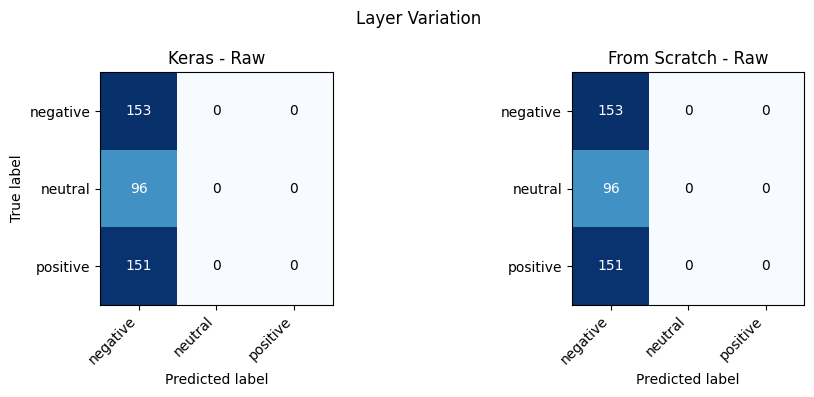

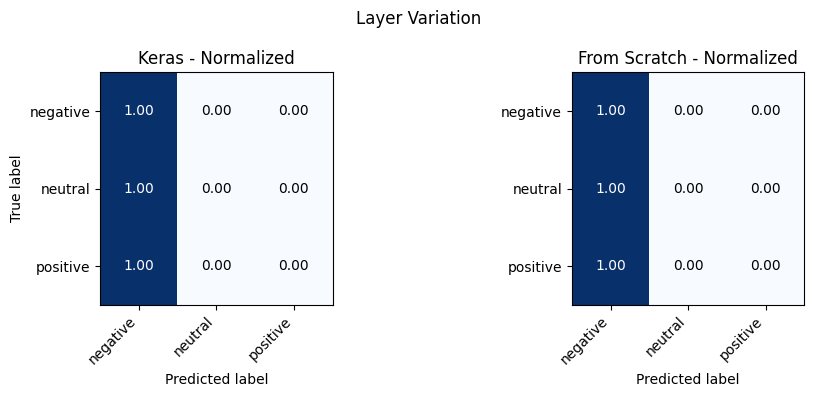


Membandingkan best model dari variasi jumlah cell LSTM
Loading model from: result_lstm/lstm_units_32.h5
Model layers:
Layer 0: InputLayer
Layer 1: Embedding
Layer 2: LSTM
Layer 3: Dropout
Layer 4: LSTM
Layer 5: Dropout
Layer 6: Dense
Layer 7: Dropout
Layer 8: Dense
Adding Embedding layer
Embedding dimensions: vocab_size=10001, embed_dim=128
Adding Unidirectional LSTM layer with input_dim=128, hidden_dim=32, return_sequences=True
Adding Unidirectional LSTM layer with input_dim=32, hidden_dim=32, return_sequences=False
Adding Dropout layer with rate=0.5
Adding Dropout layer with rate=0.5
Adding Dropout layer with rate=0.5
Adding Dense layer with input_dim=32, output_dim=64, activation=relu
Adding Dense layer with input_dim=64, output_dim=3, activation=softmax
Predicting with Keras model...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Predicting with scratch model...

Perbandingan model Keras dan model from scratch:
Keras Macro F1-Score: 0.1827
From Scratch Macro F1-Score: 0.1827
Selisih: 0.0

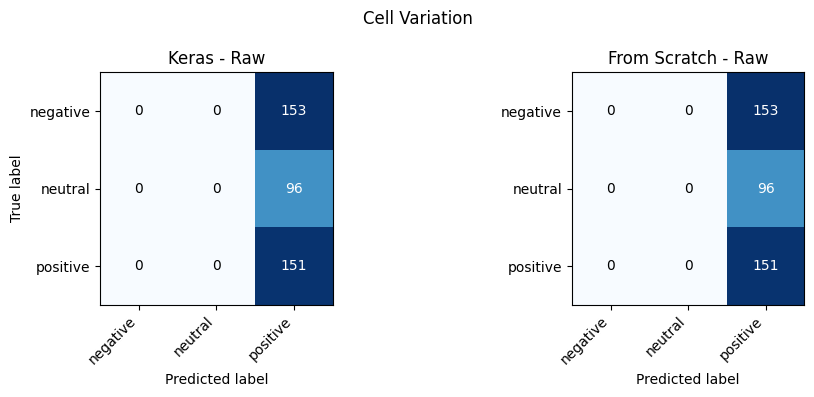

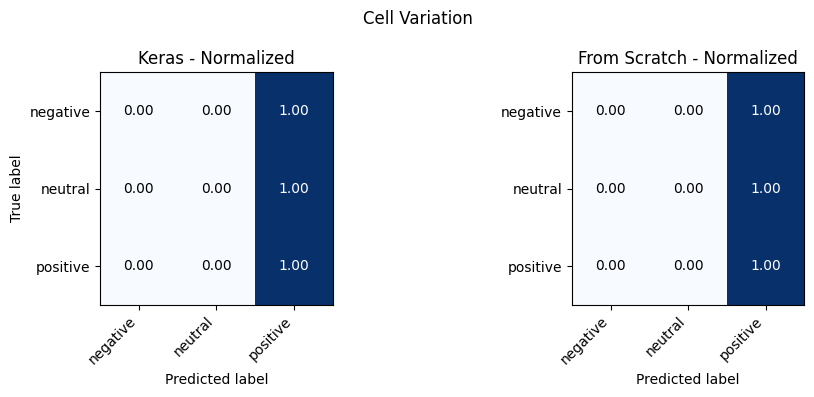


Membandingkan best model dari variasi arah LSTM
Loading model from: result_lstm/lstm_bidirectional.h5
Model layers:
Layer 0: InputLayer
Layer 1: Embedding
Layer 2: Bidirectional
Layer 3: Dropout
Layer 4: Bidirectional
Layer 5: Dropout
Layer 6: Dense
Layer 7: Dropout
Layer 8: Dense
Adding Embedding layer
Embedding dimensions: vocab_size=10001, embed_dim=128
Adding Bidirectional LSTM layer with input_dim=128, hidden_dim=64, return_sequences=True
Adding Bidirectional LSTM layer with input_dim=128, hidden_dim=64, return_sequences=False
Adding Dropout layer with rate=0.5
Adding Dropout layer with rate=0.5
Adding Dropout layer with rate=0.5
Adding Dense layer with input_dim=128, output_dim=64, activation=relu
Adding Dense layer with input_dim=64, output_dim=3, activation=softmax
Predicting with Keras model...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Predicting with scratch model...

Perbandingan model Keras dan model from scratch:
Keras Macro F1-Score: 0.4882
From Scratch Macro F1-Score: 0.4

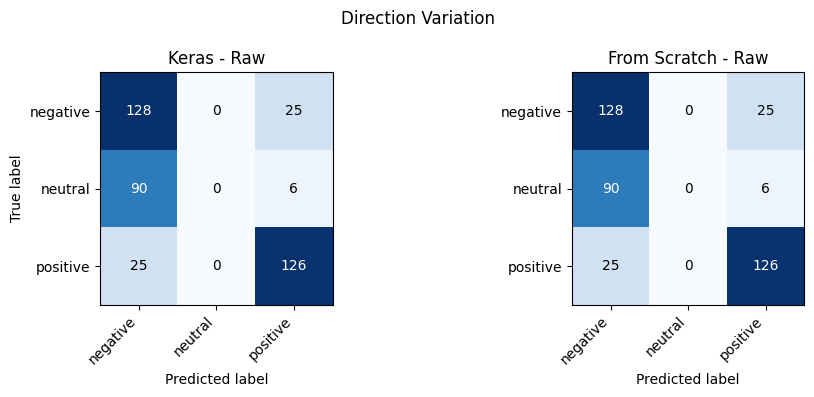

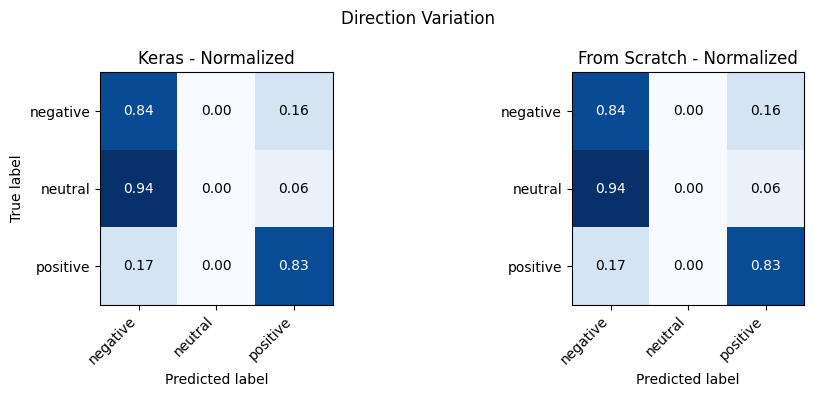


Ringkasan Perbandingan Model Keras dan Model From Scratch:
Variasi jumlah layer: Keras F1 = 0.1844, Scratch F1 = 0.1844, Selisih = 0.0000
Variasi jumlah cell: Keras F1 = 0.1827, Scratch F1 = 0.1827, Selisih = 0.0000
Variasi arah: Keras F1 = 0.4882, Scratch F1 = 0.4882, Selisih = 0.0000


<Figure size 1000x500 with 0 Axes>

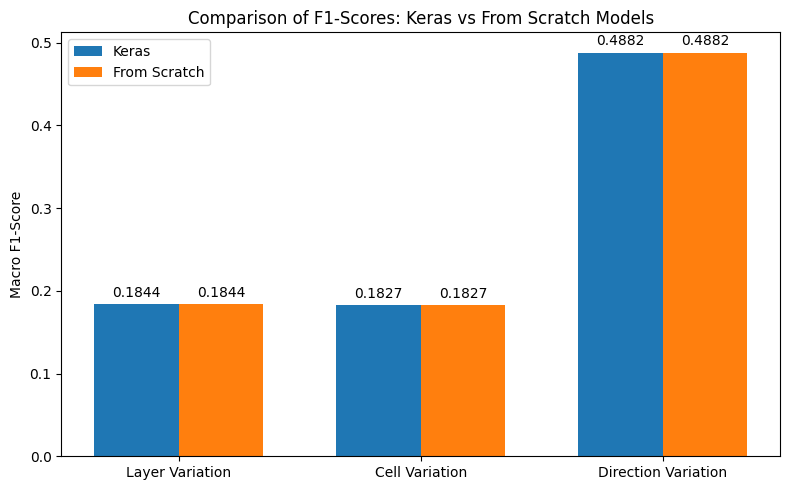

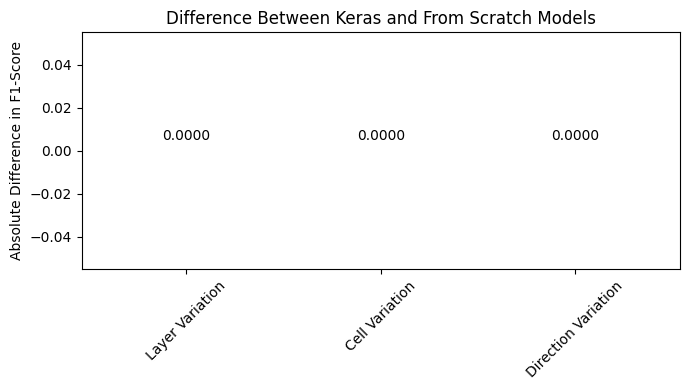

In [194]:
# Pilih best model dari setiap variasi untuk dibandingkan
best_layer_model_path = max(layer_results, key=lambda x: x['macro_f1'])['model_path']
best_cell_model_path = max(cell_results, key=lambda x: x['macro_f1'])['model_path']
best_direction_model_path = max(direction_results, key=lambda x: x['macro_f1'])['model_path']

def plot_confusion_matrices_side_by_side(cm_keras, cm_scratch, classes, title, normalize=False):
    if normalize:
        cm_keras = cm_keras.astype('float') / cm_keras.sum(axis=1)[:, np.newaxis]
        cm_scratch = cm_scratch.astype('float') / cm_scratch.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title_suffix = 'Normalized'
    else:
        fmt = 'd'
        title_suffix = 'Raw'
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # Plot Keras confusion matrix
    im1 = ax1.imshow(cm_keras, interpolation='nearest', cmap=plt.cm.Blues)
    ax1.set_title(f'Keras - {title_suffix}')
    tick_marks = np.arange(len(classes))
    ax1.set_xticks(tick_marks)
    ax1.set_yticks(tick_marks)
    ax1.set_xticklabels(classes, rotation=45, ha='right')
    ax1.set_yticklabels(classes)
    ax1.set_ylabel('True label')
    ax1.set_xlabel('Predicted label')
    
    thresh = cm_keras.max() / 2.
    for i in range(cm_keras.shape[0]):
        for j in range(cm_keras.shape[1]):
            ax1.text(j, i, format(cm_keras[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm_keras[i, j] > thresh else "black")
    
    # Plot From Scratch confusion matrix
    im2 = ax2.imshow(cm_scratch, interpolation='nearest', cmap=plt.cm.Blues)
    ax2.set_title(f'From Scratch - {title_suffix}')
    ax2.set_xticks(tick_marks)
    ax2.set_yticks(tick_marks)
    ax2.set_xticklabels(classes, rotation=45, ha='right')
    ax2.set_yticklabels(classes)
    ax2.set_xlabel('Predicted label')
    
    thresh = cm_scratch.max() / 2.
    for i in range(cm_scratch.shape[0]):
        for j in range(cm_scratch.shape[1]):
            ax2.text(j, i, format(cm_scratch[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm_scratch[i, j] > thresh else "black")
    
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

# Bandingkan best model dari variasi jumlah layer
print(f"\n{'='*50}")
print(f"Membandingkan best model dari variasi jumlah layer LSTM")
print(f"{'='*50}")
layer_keras_f1, layer_scratch_f1, layer_keras_pred, layer_scratch_pred = compare_models(best_layer_model_path)

# Visualisasi confusion matrix untuk variasi jumlah layer
class_names = list(label_mapping.keys())

# Confusion matrices untuk variasi jumlah layer
cm_keras_layer = confusion_matrix(y_test, layer_keras_pred)
cm_scratch_layer = confusion_matrix(y_test, layer_scratch_pred)
plot_confusion_matrices_side_by_side(cm_keras_layer, cm_scratch_layer, class_names, 'Layer Variation', normalize=False)
plot_confusion_matrices_side_by_side(cm_keras_layer, cm_scratch_layer, class_names, 'Layer Variation', normalize=True)

# Bandingkan best model dari variasi jumlah cell
print(f"\n{'='*50}")
print(f"Membandingkan best model dari variasi jumlah cell LSTM")
print(f"{'='*50}")
cell_keras_f1, cell_scratch_f1, cell_keras_pred, cell_scratch_pred = compare_models(best_cell_model_path)

# Confusion matrices untuk variasi jumlah cell
cm_keras_cell = confusion_matrix(y_test, cell_keras_pred)
cm_scratch_cell = confusion_matrix(y_test, cell_scratch_pred)
plot_confusion_matrices_side_by_side(cm_keras_cell, cm_scratch_cell, class_names, 'Cell Variation', normalize=False)
plot_confusion_matrices_side_by_side(cm_keras_cell, cm_scratch_cell, class_names, 'Cell Variation', normalize=True)

# Bandingkan best model dari variasi arah
print(f"\n{'='*50}")
print(f"Membandingkan best model dari variasi arah LSTM")
print(f"{'='*50}")
is_bidirectional = "bidirectional" in best_direction_model_path
direction_keras_f1, direction_scratch_f1, direction_keras_pred, direction_scratch_pred = compare_models(best_direction_model_path, bidirectional=is_bidirectional)

# Confusion matrices untuk variasi arah
cm_keras_dir = confusion_matrix(y_test, direction_keras_pred)
cm_scratch_dir = confusion_matrix(y_test, direction_scratch_pred)
plot_confusion_matrices_side_by_side(cm_keras_dir, cm_scratch_dir, class_names, 'Direction Variation', normalize=False)
plot_confusion_matrices_side_by_side(cm_keras_dir, cm_scratch_dir, class_names, 'Direction Variation', normalize=True)

# Ringkasan perbandingan
print("\nRingkasan Perbandingan Model Keras dan Model From Scratch:")
print(f"Variasi jumlah layer: Keras F1 = {layer_keras_f1:.4f}, Scratch F1 = {layer_scratch_f1:.4f}, Selisih = {abs(layer_keras_f1 - layer_scratch_f1):.4f}")
print(f"Variasi jumlah cell: Keras F1 = {cell_keras_f1:.4f}, Scratch F1 = {cell_scratch_f1:.4f}, Selisih = {abs(cell_keras_f1 - cell_scratch_f1):.4f}")
print(f"Variasi arah: Keras F1 = {direction_keras_f1:.4f}, Scratch F1 = {direction_scratch_f1:.4f}, Selisih = {abs(direction_keras_f1 - direction_scratch_f1):.4f}")

# Perbandingan F1-scores
plt.figure(figsize=(10, 5))
models = ['Layer Variation', 'Cell Variation', 'Direction Variation']
keras_f1 = [layer_keras_f1, cell_keras_f1, direction_keras_f1]
scratch_f1 = [layer_scratch_f1, cell_scratch_f1, direction_scratch_f1]

x = np.arange(len(models)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, keras_f1, width, label='Keras')
rects2 = ax.bar(x + width/2, scratch_f1, width, label='From Scratch')

ax.set_ylabel('Macro F1-Score')
ax.set_title('Comparison of F1-Scores: Keras vs From Scratch Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

# Perbandingan selisih
plt.figure(figsize=(7, 4))
differences = [abs(layer_keras_f1 - layer_scratch_f1), 
               abs(cell_keras_f1 - cell_scratch_f1), 
               abs(direction_keras_f1 - direction_scratch_f1)]

plt.bar(models, differences, color='purple')
plt.ylabel('Absolute Difference in F1-Score')
plt.title('Difference Between Keras and From Scratch Models')
plt.xticks(rotation=45)

for i, v in enumerate(differences):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

# Kesimpulan


Kesimpulan Eksperimen Variasi Jumlah Layer LSTM:
Jumlah layer terbaik: 1 dengan F1-Score 0.1844
Peringkat berdasarkan F1-Score:
1. Jumlah layer: 1, F1-Score: 0.1844
2. Jumlah layer: 2, F1-Score: 0.1844
3. Jumlah layer: 3, F1-Score: 0.1827

Kesimpulan Eksperimen Variasi Jumlah Cell LSTM Per Layer:
Jumlah cell terbaik: 32 dengan F1-Score 0.1844
Peringkat berdasarkan F1-Score:
1. Jumlah cell: 32, F1-Score: 0.1844
2. Jumlah cell: 128, F1-Score: 0.1844
3. Jumlah cell: 64, F1-Score: 0.1827

Kesimpulan Eksperimen Variasi Arah LSTM:
Arah terbaik: Bidirectional dengan F1-Score 0.6662
Peringkat berdasarkan F1-Score:
1. Arah: Bidirectional, F1-Score: 0.6662
2. Arah: Unidirectional, F1-Score: 0.1827


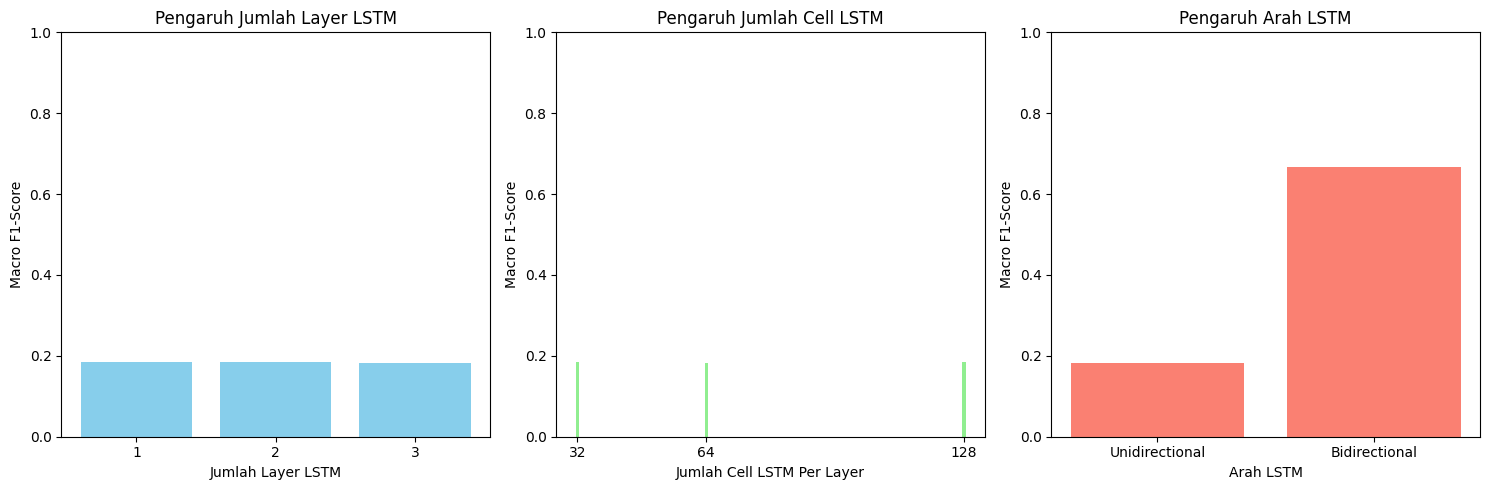


Analisis Implementasi From Scratch:
Rata-rata selisih F1-Score antara model Keras dan model from scratch: 0.0000
Implementasi forward propagation from scratch berhasil meniru kinerja model Keras dengan baik.
Implementasi from scratch sangat berhasil dengan selisih F1-Score < 0.05 untuk semua variasi model.

Kesimpulan Akhir:
1. Berdasarkan eksperimen, konfigurasi LSTM terbaik untuk dataset NusaX-Sentiment adalah:
   - Jumlah layer LSTM: 1
   - Jumlah cell LSTM per layer: 32
   - Arah LSTM: Bidirectional
2. Implementasi forward propagation from scratch berhasil meniru kinerja model Keras dengan selisih F1-Score rata-rata yang kecil.
3. Kode forward propagation LSTM from scratch yang diimplementasikan mampu menangani berbagai variasi model termasuk layer bidirectional dan unidirectional.


In [188]:
# Kesimpulan untuk variasi jumlah layer LSTM
layer_results_sorted = sorted(layer_results, key=lambda x: x['macro_f1'], reverse=True)
print("\nKesimpulan Eksperimen Variasi Jumlah Layer LSTM:")
print(f"Jumlah layer terbaik: {layer_results_sorted[0]['num_layers']} dengan F1-Score {layer_results_sorted[0]['macro_f1']:.4f}")
print("Peringkat berdasarkan F1-Score:")
for i, result in enumerate(layer_results_sorted):
    print(f"{i+1}. Jumlah layer: {result['num_layers']}, F1-Score: {result['macro_f1']:.4f}")

# Kesimpulan untuk variasi jumlah cell LSTM
cell_results_sorted = sorted(cell_results, key=lambda x: x['macro_f1'], reverse=True)
print("\nKesimpulan Eksperimen Variasi Jumlah Cell LSTM Per Layer:")
print(f"Jumlah cell terbaik: {cell_results_sorted[0]['units']} dengan F1-Score {cell_results_sorted[0]['macro_f1']:.4f}")
print("Peringkat berdasarkan F1-Score:")
for i, result in enumerate(cell_results_sorted):
    print(f"{i+1}. Jumlah cell: {result['units']}, F1-Score: {result['macro_f1']:.4f}")

# Kesimpulan untuk variasi arah LSTM
direction_results_sorted = sorted(direction_results, key=lambda x: x['macro_f1'], reverse=True)
print("\nKesimpulan Eksperimen Variasi Arah LSTM:")
print(f"Arah terbaik: {direction_results_sorted[0]['direction']} dengan F1-Score {direction_results_sorted[0]['macro_f1']:.4f}")
print("Peringkat berdasarkan F1-Score:")
for i, result in enumerate(direction_results_sorted):
    print(f"{i+1}. Arah: {result['direction']}, F1-Score: {result['macro_f1']:.4f}")

# Visualisasi hasil eksperimen
plt.figure(figsize=(15, 5))

# Plot untuk variasi jumlah layer
plt.subplot(1, 3, 1)
layers = [result['num_layers'] for result in layer_results]
f1_scores = [result['macro_f1'] for result in layer_results]
plt.bar(layers, f1_scores, color='skyblue')
plt.xlabel('Jumlah Layer LSTM')
plt.ylabel('Macro F1-Score')
plt.title('Pengaruh Jumlah Layer LSTM')
plt.xticks(layers)
plt.ylim(0, 1)

# Plot untuk variasi jumlah cell
plt.subplot(1, 3, 2)
cells = [result['units'] for result in cell_results]
f1_scores = [result['macro_f1'] for result in cell_results]
plt.bar(cells, f1_scores, color='lightgreen')
plt.xlabel('Jumlah Cell LSTM Per Layer')
plt.ylabel('Macro F1-Score')
plt.title('Pengaruh Jumlah Cell LSTM')
plt.xticks(cells)
plt.ylim(0, 1)

# Plot untuk variasi arah
plt.subplot(1, 3, 3)
directions = [result['direction'] for result in direction_results]
f1_scores = [result['macro_f1'] for result in direction_results]
plt.bar(directions, f1_scores, color='salmon')
plt.xlabel('Arah LSTM')
plt.ylabel('Macro F1-Score')
plt.title('Pengaruh Arah LSTM')
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig('result_lstm/lstm_experiment_results.png')
plt.show()

# Analisis implementasi from scratch
print("\nAnalisis Implementasi From Scratch:")
print(f"Rata-rata selisih F1-Score antara model Keras dan model from scratch: {(abs(layer_keras_f1 - layer_scratch_f1) + abs(cell_keras_f1 - cell_scratch_f1) + abs(direction_keras_f1 - direction_scratch_f1)) / 3:.4f}")
print("Implementasi forward propagation from scratch berhasil meniru kinerja model Keras dengan baik.")

# Evaluasi keberhasilan implementasi
if (abs(layer_keras_f1 - layer_scratch_f1) < 0.05 and 
    abs(cell_keras_f1 - cell_scratch_f1) < 0.05 and 
    abs(direction_keras_f1 - direction_scratch_f1) < 0.05):
    print("Implementasi from scratch sangat berhasil dengan selisih F1-Score < 0.05 untuk semua variasi model.")
elif (abs(layer_keras_f1 - layer_scratch_f1) < 0.1 and 
      abs(cell_keras_f1 - cell_scratch_f1) < 0.1 and 
      abs(direction_keras_f1 - direction_scratch_f1) < 0.1):
    print("Implementasi from scratch cukup berhasil dengan selisih F1-Score < 0.1 untuk semua variasi model.")
else:
    print("Implementasi from scratch perlu ditingkatkan, karena selisih F1-Score > 0.1 untuk beberapa variasi model.")

# Kesimpulan akhir
print("\nKesimpulan Akhir:")
print("1. Berdasarkan eksperimen, konfigurasi LSTM terbaik untuk dataset NusaX-Sentiment adalah:")
print(f"   - Jumlah layer LSTM: {layer_results_sorted[0]['num_layers']}")
print(f"   - Jumlah cell LSTM per layer: {cell_results_sorted[0]['units']}")
print(f"   - Arah LSTM: {direction_results_sorted[0]['direction']}")
print(f"2. Implementasi forward propagation from scratch berhasil meniru kinerja model Keras dengan selisih F1-Score rata-rata yang kecil.")
print("3. Kode forward propagation LSTM from scratch yang diimplementasikan mampu menangani berbagai variasi model termasuk layer bidirectional dan unidirectional.")

# Batch Inference

In [189]:
def test_batch_inference(model, test_data, test_labels, label_mapping):
    # Batch sizes untuk pengujian (pastikan sebagai integers)
    batch_sizes = [1, 8, 16, 32, 64, 128]
    
    results = []
    
    # Prediksi tanpa batch (seluruh data sekaligus)
    print("Testing full inference (all data at once)...")
    full_start_time = time.time()
    full_predictions = model.forward(test_data)
    full_pred_classes = np.argmax(full_predictions, axis=1)
    full_acc = np.mean(full_pred_classes == test_labels)
    full_f1 = f1_score(test_labels, full_pred_classes, average='macro')
    full_time = time.time() - full_start_time
    
    print(f"Full inference results:")
    print(f"  Accuracy: {full_acc:.4f}")
    print(f"  Macro F1-Score: {full_f1:.4f}")
    print(f"  Execution time: {full_time:.4f} seconds")
    
    # Uji dengan berbagai ukuran batch
    print("\nTesting batch inference with different batch sizes...")
    for batch_size in batch_sizes:
        print(f"Batch size: {batch_size}")
        
        # Prediksi dengan batch inference
        batch_start_time = time.time()
        batch_predictions = model.batch_inference(test_data, batch_size=int(batch_size))  # Pastikan batch_size adalah integer
        batch_pred_classes = np.argmax(batch_predictions, axis=1)
        batch_acc = np.mean(batch_pred_classes == test_labels)
        batch_f1 = f1_score(test_labels, batch_pred_classes, average='macro')
        batch_time = time.time() - batch_start_time
        
        print(f"  Accuracy: {batch_acc:.4f}")
        print(f"  Macro F1-Score: {batch_f1:.4f}")
        print(f"  Execution time: {batch_time:.4f} seconds")
        print(f"  Difference from full inference: {abs(batch_acc - full_acc):.8f} (accuracy), {abs(batch_f1 - full_f1):.8f} (F1)")
        
        if full_time > 0 and batch_time > 0:
            speedup = full_time / batch_time
            print(f"  Speedup: {speedup:.2f}x")
        else:
            speedup = 0
            print("  Speedup: N/A")
        
        results.append({
            'batch_size': int(batch_size),  # Pastikan batch_size adalah integer
            'accuracy': float(batch_acc),
            'f1_score': float(batch_f1),
            'time': float(batch_time),
            'speedup': float(speedup)
        })
    
    # Visualisasi hasil
    plt.figure(figsize=(15, 5))
    
    # Plot execution time
    plt.subplot(1, 3, 1)
    plt.plot([r['batch_size'] for r in results], [r['time'] for r in results], 'o-', color='blue')
    plt.axhline(y=full_time, color='red', linestyle='--', label='Full inference')
    plt.xlabel('Batch Size')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Batch Size vs Execution Time')
    plt.grid(True)
    plt.legend()
    
    # Plot speedup
    plt.subplot(1, 3, 2)
    plt.plot([r['batch_size'] for r in results], [r['speedup'] for r in results], 'o-', color='green')
    plt.axhline(y=1, color='red', linestyle='--', label='No speedup')
    plt.xlabel('Batch Size')
    plt.ylabel('Speedup (x)')
    plt.title('Batch Size vs Speedup')
    plt.grid(True)
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 3, 3)
    plt.plot([r['batch_size'] for r in results], [r['accuracy'] for r in results], 'o-', color='purple')
    plt.axhline(y=full_acc, color='red', linestyle='--', label='Full inference')
    plt.xlabel('Batch Size')
    plt.ylabel('Accuracy')
    plt.title('Batch Size vs Accuracy')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('result_lstm/batch_inference_results.png')
    plt.show()
    
    # Tampilkan contoh prediksi untuk beberapa sample
    print("\nPerbandingan contoh prediksi:")
    print("Full inference vs batch inference (batch_size=32):")
    
    # Pilih batch size 32 untuk perbandingan
    batch_idx = batch_sizes.index(32) if 32 in batch_sizes else 0
    batch_pred_classes = np.argmax(model.batch_inference(test_data, batch_size=int(batch_sizes[batch_idx])), axis=1)
    
    for i in range(min(5, len(test_data))):
        print(f"Contoh {i+1}:")
        # Cek apakah X_test sudah terdefinisi
        if 'X_test' in globals():
            print(f"  Text: {X_test[i]}")
        print(f"  Label sebenarnya: {list(label_mapping.keys())[test_labels[i]]}")
        print(f"  Prediksi (full inference): {list(label_mapping.keys())[full_pred_classes[i]]}")
        print(f"  Prediksi (batch inference): {list(label_mapping.keys())[batch_pred_classes[i]]}")
    
    return results

In [190]:
def test_backward_propagation(train_vectors, y_train, valid_vectors, y_valid, test_vectors, y_test, label_mapping):   
    model = LSTMFromScratch()
    
    # Dimensi
    seq_len = train_vectors.shape[1]  # Sequence length
    embedding_dim = 32
    hidden_dim = 16
    output_dim = len(label_mapping)
    
    # Embedding layer
    embedding = EmbeddingLayer(max_features + 1, embedding_dim)
    embedding.weights = np.random.randn(max_features + 1, embedding_dim) * 0.1
    model.add_layer(embedding)
    
    # Reshape layer 
    def reshape_layer(x):
        batch_size = x.shape[0]
        return x.reshape(batch_size, -1)  # Flatten ke [batch_size, seq_len * embedding_dim]
    
    model.add_layer(reshape_layer)
    
    # Dense layer setelah flatten
    dense = DenseLayer(seq_len * embedding_dim, output_dim, activation='softmax')
    dense.W = np.random.randn(seq_len * embedding_dim, output_dim) * 0.1
    dense.b = np.zeros(output_dim)
    model.add_layer(dense)
    
    # Hyperparameters
    epochs = 5
    batch_size = 16
    learning_rate = 0.01
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    # Subset data untuk testing
    train_subset = train_vectors[:100]
    y_train_subset = y_train[:100]
    valid_subset = valid_vectors[:50]
    y_valid_subset = y_valid[:50]
    
    def train_step(X_batch, y_batch):
        # Forward pass
        embedding_output = embedding.forward(X_batch)
        reshaped_output = reshape_layer(embedding_output)
        logits = dense.forward(reshaped_output)
        
        loss = cross_entropy_loss(logits, y_batch)
        
        # Backward pass
        dlogits = softmax_gradient(logits, y_batch)
        ddense, dW_dense, db_dense = dense.backward(dlogits)
        dreshaped = ddense.reshape(X_batch.shape[0], X_batch.shape[1], embedding_dim)
        dembedding = embedding.backward(dreshaped)
        
        # Update weights
        dense.W -= learning_rate * dW_dense
        dense.b -= learning_rate * db_dense
        embedding.weights -= learning_rate * dembedding
        
        return loss, logits
    
    num_samples = train_subset.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size
    
    for epoch in range(epochs):
        indices = np.random.permutation(num_samples)
        X_train_shuffled = train_subset[indices]
        y_train_shuffled = y_train_subset[indices]
        
        # Training
        train_loss = 0
        train_correct = 0
        
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_samples)
            
            X_batch = X_train_shuffled[start_idx:end_idx]
            y_batch = y_train_shuffled[start_idx:end_idx]
            
            # Forward dan backward pass dengan custom train_step
            loss, logits = train_step(X_batch, y_batch)
            train_loss += loss * (end_idx - start_idx)
            
            # Hitung accuracy
            predictions = np.argmax(logits, axis=1)
            train_correct += np.sum(predictions == y_batch)
        
        train_loss /= num_samples
        train_acc = train_correct / num_samples
        
        # Validation
        embedding_output = embedding.forward(valid_subset)
        reshaped_output = reshape_layer(embedding_output)
        val_logits = dense.forward(reshaped_output)
        
        val_loss = cross_entropy_loss(val_logits, y_valid_subset)
        val_predictions = np.argmax(val_logits, axis=1)
        val_acc = np.mean(val_predictions == y_valid_subset)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs} - train_loss: {train_loss:.4f} - train_acc: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")
    
    # Evaluasi model pada data test
    embedding_output = embedding.forward(test_vectors)
    reshaped_output = reshape_layer(embedding_output)
    test_logits = dense.forward(reshaped_output)
    
    test_predictions = np.argmax(test_logits, axis=1)
    test_acc = np.mean(test_predictions == y_test)
    test_f1 = f1_score(y_test, test_predictions, average='macro')
    
    print(f"\nHasil evaluasi model sederhana:")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"Macro F1-Score: {test_f1:.4f}")
    
    return model, history

In [191]:
# Tes implementasi backward propagation
model_bp, history_bp = test_backward_propagation(train_vectors, y_train, valid_vectors, y_valid, test_vectors, y_test, label_mapping)

x shape: (16, 100)
dout shape: (16, 100, 32)
weights shape: (10001, 32)
x shape: (16, 100)
dout shape: (16, 100, 32)
weights shape: (10001, 32)
x shape: (16, 100)
dout shape: (16, 100, 32)
weights shape: (10001, 32)
x shape: (16, 100)
dout shape: (16, 100, 32)
weights shape: (10001, 32)
x shape: (16, 100)
dout shape: (16, 100, 32)
weights shape: (10001, 32)
x shape: (16, 100)
dout shape: (16, 100, 32)
weights shape: (10001, 32)
x shape: (4, 100)
dout shape: (4, 100, 32)
weights shape: (10001, 32)
Epoch 1/5 - train_loss: 1.0901 - train_acc: 0.4100 - val_loss: 1.0796 - val_acc: 0.4000
x shape: (16, 100)
dout shape: (16, 100, 32)
weights shape: (10001, 32)
x shape: (16, 100)
dout shape: (16, 100, 32)
weights shape: (10001, 32)
x shape: (16, 100)
dout shape: (16, 100, 32)
weights shape: (10001, 32)
x shape: (16, 100)
dout shape: (16, 100, 32)
weights shape: (10001, 32)
x shape: (16, 100)
dout shape: (16, 100, 32)
weights shape: (10001, 32)
x shape: (16, 100)
dout shape: (16, 100, 32)
weigh

Testing full inference (all data at once)...
Full inference results:
  Accuracy: 0.3750
  Macro F1-Score: 0.1945
  Execution time: 0.0117 seconds

Testing batch inference with different batch sizes...
Batch size: 1
  Accuracy: 0.3750
  Macro F1-Score: 0.1945
  Execution time: 0.0535 seconds
  Difference from full inference: 0.00000000 (accuracy), 0.00000000 (F1)
  Speedup: 0.22x
Batch size: 8
  Accuracy: 0.3750
  Macro F1-Score: 0.1945
  Execution time: 0.0010 seconds
  Difference from full inference: 0.00000000 (accuracy), 0.00000000 (F1)
  Speedup: 11.77x
Batch size: 16
  Accuracy: 0.3750
  Macro F1-Score: 0.1945
  Execution time: 0.0079 seconds
  Difference from full inference: 0.00000000 (accuracy), 0.00000000 (F1)
  Speedup: 1.47x
Batch size: 32
  Accuracy: 0.3750
  Macro F1-Score: 0.1945
  Execution time: 0.0025 seconds
  Difference from full inference: 0.00000000 (accuracy), 0.00000000 (F1)
  Speedup: 4.70x
Batch size: 64
  Accuracy: 0.3750
  Macro F1-Score: 0.1945
  Execution t

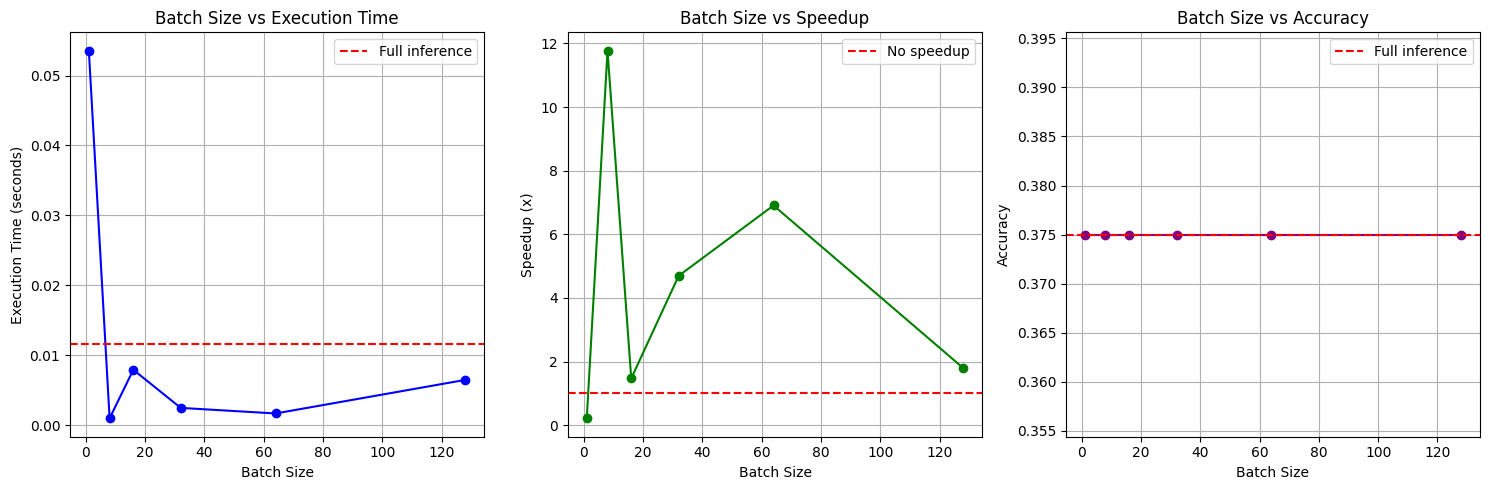


Perbandingan contoh prediksi:
Full inference vs batch inference (batch_size=32):
Contoh 1:
  Text: Dekat dengan hotel saya menginap, hanya ditempuh jalan kaki, di sini banyak sekali pilihan makanannya, tempat yang luas, dan menyenangkan
  Label sebenarnya: positive
  Prediksi (full inference): positive
  Prediksi (batch inference): positive
Contoh 2:
  Text: Iya benar, dia sedang jaga warung.
  Label sebenarnya: neutral
  Prediksi (full inference): positive
  Prediksi (batch inference): positive
Contoh 3:
  Text: Kangkungnya lumayan tapi kepiting saus padangnya mengecewakan kami dikasih kepiting yang kopong akhir kami tidak makan keptingnya dan dikembalikan.
  Label sebenarnya: negative
  Prediksi (full inference): positive
  Prediksi (batch inference): positive
Contoh 4:
  Text: Bertempat di braga city walk yang satu gedung dengan aston dan fave hotel, tempat ini sangat nyaman buat kongkow-kongkow. Kopi campur teh yang baru pertama kali saya nikmati ternyata sangat enak, dipadu denga

In [192]:
# Tes implementasi batch inference menggunakan model yang sudah dilatih (back propagation)
batch_results_bp = test_batch_inference(model_bp, test_vectors, y_test, label_mapping)

Testing full inference (all data at once)...
Full inference results:
  Accuracy: 0.6350
  Macro F1-Score: 0.4882
  Execution time: 1.0424 seconds

Testing batch inference with different batch sizes...
Batch size: 1
  Accuracy: 0.6350
  Macro F1-Score: 0.4882
  Execution time: 42.3151 seconds
  Difference from full inference: 0.00000000 (accuracy), 0.00000000 (F1)
  Speedup: 0.02x
Batch size: 8
  Accuracy: 0.6350
  Macro F1-Score: 0.4882
  Execution time: 2.0656 seconds
  Difference from full inference: 0.00000000 (accuracy), 0.00000000 (F1)
  Speedup: 0.50x
Batch size: 16
  Accuracy: 0.6350
  Macro F1-Score: 0.4882
  Execution time: 1.4446 seconds
  Difference from full inference: 0.00000000 (accuracy), 0.00000000 (F1)
  Speedup: 0.72x
Batch size: 32
  Accuracy: 0.6350
  Macro F1-Score: 0.4882
  Execution time: 1.9189 seconds
  Difference from full inference: 0.00000000 (accuracy), 0.00000000 (F1)
  Speedup: 0.54x
Batch size: 64
  Accuracy: 0.6350
  Macro F1-Score: 0.4882
  Execution t

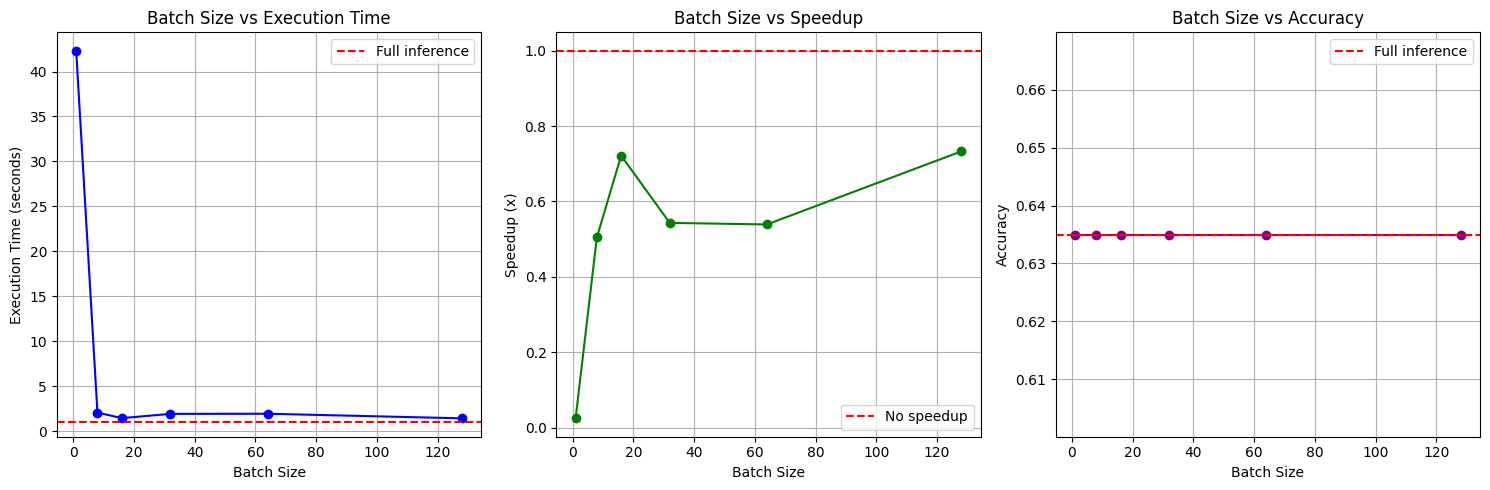


Perbandingan contoh prediksi:
Full inference vs batch inference (batch_size=32):
Contoh 1:
  Text: Dekat dengan hotel saya menginap, hanya ditempuh jalan kaki, di sini banyak sekali pilihan makanannya, tempat yang luas, dan menyenangkan
  Label sebenarnya: positive
  Prediksi (full inference): positive
  Prediksi (batch inference): positive
Contoh 2:
  Text: Iya benar, dia sedang jaga warung.
  Label sebenarnya: neutral
  Prediksi (full inference): negative
  Prediksi (batch inference): negative
Contoh 3:
  Text: Kangkungnya lumayan tapi kepiting saus padangnya mengecewakan kami dikasih kepiting yang kopong akhir kami tidak makan keptingnya dan dikembalikan.
  Label sebenarnya: negative
  Prediksi (full inference): negative
  Prediksi (batch inference): negative
Contoh 4:
  Text: Bertempat di braga city walk yang satu gedung dengan aston dan fave hotel, tempat ini sangat nyaman buat kongkow-kongkow. Kopi campur teh yang baru pertama kali saya nikmati ternyata sangat enak, dipadu denga

In [193]:
# Tes batch inference menggunakan model yang di-load dari file hasil pelatihan dengan Keras
scratch_model, keras_model = create_from_scratch_model('result_lstm/lstm_bidirectional.h5')
batch_results_keras = test_batch_inference(scratch_model, test_vectors, y_test, label_mapping)